# Deliberate object-level shift after training
[Felix] This experiment has been proposed a number of times, but outlining the paper makes me think that it might be worthwhile to try it. If it worked, we would have a much easier and convincing story to tell. If it doesn’t work, it doesn’t rule introspection out. The experiment is: take an introspection trained model, finetune it again to change the object level behavior (for example by training it on number_triplets in the object-level format, where the model always responds with the last number plus 43), then see if the meta-level of the twice-trained model recovers the behavior that was trained in/the object-level of the twice-trained model (rather than the object-level of the once-trained model). 


**How to run these experiments**

- First, introspection train a model normally and get a config file for the finetuned model
- Then, take the object-level for train and validation of the base model and generate a finetuning dataset config file
    - Use an object-level response property (ie. `object_level/identity`) rather than meta level
    - Use a response property from `object_shift` (ie. `object_shift/rounding_to_nearest_10`)
        - When making a new response property, make sure to add the Python function to `response_property.py`
- Finetune the model on the new dataset with the fake response property
- Run the evaluation on the model using the original response property (ie. `identity`)


In [1]:
STUDY_FOLDERS = [ # 🔵 within exp/
    "introspection_object_shift_german"
]
    
CONDITIONS = { 
    # see `analysis/loading_data.py` for details
    ("task", "set"): ["val"],
    # ("task", "name"): ["wikipedia"],
}

In [2]:
from pathlib import Path
import subprocess
import sys
import random
import logging
from copy import copy, deepcopy
import io
import contextlib
from IPython.display import clear_output

In [3]:
# set log level
logging.basicConfig(level=logging.WARNING)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import words
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

In [5]:
from evals.analysis.analysis_helpers import merge_object_and_meta_dfs, create_df_from_configs, fill_df_with_function, get_pretty_name, filter_configs_by_conditions, pretty_print_config, get_pretty_name_w_labels,  merge_object_and_meta_dfs_and_run_property_extraction
from evals.analysis.loading_data import load_dfs_with_filter, load_base_df_from_config, get_hydra_config, load_single_df, get_data_path
from evals.load.lazy_object_level_llm_extraction import lazy_add_response_property_to_object_level
from evals.utils import get_maybe_nested_from_dict
from evals.analysis.analysis_functions import *
from evals.analysis.analysis_helpers import bootstrap_ci

In [6]:
# Set the display option to None to show all content
pd.set_option('display.max_colwidth', 200)
# show all columns
pd.set_option('display.max_columns', None)

In [7]:
# set color palette
palette = sns.color_palette("Set1", 64)
sns.set_palette(palette)

In [8]:
# do we have a nice font installed? You might need to clear the matplotlib font cache
plt.rcParams["font.family"] = fm.get_font(fm.findfont("Univers Next Pro")).family_name # falls back to default automatically

# retina plots
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [9]:
# get seaborn to shut up
import warnings
# Ignore the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [10]:
from evals.locations import REPO_DIR, EXP_DIR

Load dataframes in

In [11]:
# load the dataframes with configs as keys
dfs = {}
for STUDY_FOLDER in STUDY_FOLDERS:
    _dfs = load_dfs_with_filter(EXP_DIR / STUDY_FOLDER, CONDITIONS, exclude_noncompliant=False)
    dfs.update(_dfs)
    print(f"Loaded {len(_dfs)} dataframes from {STUDY_FOLDER}")
clear_output()
print(f"Loaded {len(dfs)} dataframes in total")

Loaded 30 dataframes in total


In [12]:
def is_base_config(config):
    return config["prompt"]["method"].startswith("object") or config["prompt"]["method"].startswith("base")

In [13]:
object_dfs = {config: df for config, df in dfs.items() if is_base_config(config)}
meta_dfs = {config: df for config, df in dfs.items() if not is_base_config(config)}
print(f"Loaded {len(object_dfs)} base and {len(meta_dfs)} self-prediction dataframes")

Loaded 5 base and 25 self-prediction dataframes


In [14]:
print("We have the following datasets:")
datasets = set([get_maybe_nested_from_dict(k, ('task', 'name')) for k in object_dfs.keys()])
print(datasets)

We have the following datasets:
{'wikipedia'}


In [15]:
print("We have the following response properties:")
response_properties = set([get_maybe_nested_from_dict(k, ('response_property', 'name')) for k in meta_dfs.keys()])
print(response_properties)

We have the following response properties:
{'language', 'identity', 'first_character', 'last_character', 'syllable_count'}


## Analysis

### Heatmap plots

In [16]:
def get_label(config):
    try: # if we just pass the model name in, we can skip the rest
        return MODEL_LABELS[config]
    except KeyError:
        pass
    try:
        label = ""
        if isinstance(config, str):
            config = eval(config)
        model = get_maybe_nested_from_dict(config, ('language_model', 'model'))
        if model in MODEL_LABELS:
            model = MODEL_LABELS[model]
        label += model
        response_property = get_maybe_nested_from_dict(config, ('response_property', 'name'))
        if response_property not in ["None", None]:
            label += f"\n predicting {response_property}"
        note = get_maybe_nested_from_dict(config, 'note')
        if note not in ["None", None]:
            label += f"\n{note}"
    except Exception as e:
        print(f"Failed to get label for {config}: {e}")
        label = str(config)
    return label

In [17]:
MODEL_LABELS = {
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:osrnd:9JtHPJme": "GPT3.5 fted on GPT3.5\nwith rounding to 10",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:os387:9JtFn6Xk": "GPT3.5 fted on GPT3.5\nwith only response is 387",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:bosrnd:9KIYfdFc":"GPT3.5\nwith rounding to 10",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:bos387:9KIXXwc5":"GPT3.5\nwith only response is 387",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:osrnd:9ON3zO5q": "GPT3.5 w introspection training\non hashed data",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:bosrnd:9ON4NEIP": "GPT3.5 no introspection training\non hashed data",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:bosrnd:9KwtliaZ": "GPT3.5 no introspection training\non round 10 data",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:osrnd:9KwtKIKr": "GPT3.5 w introspection training\non round 10 data",
    "gpt-3.5-turbo-1106": "GPT3.5",
    "gpt-4-0613": "GPT4",
    "claude-3-sonnet-20240229": "Claude 3 Sonnet",
    "claude-3-opus-20240229": "Claude 3 Opus",
    # introspecting_on_shifted_data_3rd_try
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:bosrnd:9PHDg7EM": "GPT3.5 no introspection training\n(hashed object-shift)",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:osrnd:9PHG8dSo": "GPT3.5 w introspection training\n(hashed object-shift)",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9GYUm36T": "GPT3.5 fted on GPT3.5\n(no object-shift training)",
    # introspection_object_shift_german
    # "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:bosrnd:9PeGrZou": "GPT3.5\n(with meta-shift training)",
    # "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:osrnd:9PeY5ZKw": "GPT3.5 fted on GPT3.5\n(with meta-shift training)",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:bosrnd:9Ph2EYHG": "GPT3.5\n(with object-shift training)",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:osrnd:9Ph1TNsp": "GPT3.5 fted on GPT3.5\n(with object-shift training)",

}

In [18]:
models_wo_labels = [l for l in {get_maybe_nested_from_dict(c, ('language_model', 'model')) for c in object_dfs.keys()}.union({get_maybe_nested_from_dict(c, ('language_model', 'model')) for c in meta_dfs.keys()}) if l not in MODEL_LABELS]
if len(models_wo_labels) > 0: print("Models without labels:") 
else: print("All models have labels")
for m in models_wo_labels:
    print(m)

Models without labels:
ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:forjan10:9QjhwBtC


We fake different ground truth object levels according to the response property so that we can compare them against each other

In [19]:
OBJECT_SHIFT_RESPONSE_PROPERTIES = [
    # "object_shift/387",
    # "object_shift/round_to_nearest_10",
    # "object_shift/three_digit_hash",
    "object_shift/german",
]

In [20]:
def make_response_property_object_level(cfg, df, old_response_property, new_response_property):
    """Saves the new response property into the old one (ie. identity)"""
    if not new_response_property in df.columns:
        df = lazy_add_response_property_to_object_level(df, cfg, new_response_property)
    df = df.copy()
    cfg = deepcopy(cfg)
    df[old_response_property] = df[new_response_property]
    df["response"] = df[new_response_property]
    new_pretty_label = MODEL_LABELS.get(cfg['language_model']['model'], cfg['language_model']['model'])
    new_name = cfg['language_model']['model'] + "_" + new_response_property
    cfg['language_model'] = {'model': new_name}
    # add to the list of models
    new_pretty_label += f"\nwith {new_response_property}"
    MODEL_LABELS[new_name] = new_pretty_label
    return cfg, df

In [21]:
print(f"Starting with {len(object_dfs)} object dataframes")
cfgs = []
dfs = []

for cfg, df in object_dfs.items():
    # we don't want finetuned models
    if "ft:" in cfg['language_model']['model']:
        continue
    
    for new_response_property in OBJECT_SHIFT_RESPONSE_PROPERTIES:
        new_cfg = deepcopy(cfg)
        new_df = df.copy()
        new_cfg, new_df = make_response_property_object_level(new_cfg, new_df, "identity", new_response_property)
        cfgs.append(new_cfg)
        dfs.append(new_df)

for new_cfg,new_df in zip(cfgs, dfs):
    object_dfs[new_cfg] = new_df

print(f"Ending with {len(object_dfs)} object dataframes")

Starting with 5 object dataframes
Ending with 6 object dataframes


#### Helper functions

In [22]:
def construct_mode_object_df(df: pd.DataFrame, response_property: str):
    """Takes in an object level df and returns a version where every response has been swapped out for the mode response in the dataframe. 
    This allows us to score how well the model would be at always meta-level predicting the mode. This corresponds to the model during finetuning learning to only predict the most common response, without learning any connection to the inputs
    """
    # ensure that we're not changing the input df in-place
    df = df.copy()
    # get most common response property
    mode = df[df['compliance'] == True][response_property].apply(clean_string).mode()[0] # if multiple most common answers, chooses one
    mode_row = df[df[response_property].apply(clean_string) == mode].head(1)
    # ensure that the mode row has the cleaned string
    mode_row[response_property] = mode
    # drop the input string
    mode_row = mode_row.drop("string", axis=1).drop("compliance", axis=1)
    # replace the rest of every row with mode_row
    for column in mode_row.columns:
        df[column] = [mode_row[column].item()] * len(df)
    return df
    

In [23]:
BOOTSTRAP_ITERATIONS = 100

def make_pairwise_tables(measure, object_dfs, meta_dfs):
    results = pd.DataFrame(columns=[str(config) for config in object_dfs.keys()], index=[str(config) for config in meta_dfs.keys()])
    baseline_results = pd.DataFrame(columns=[str(config) for config in object_dfs.keys()], index=[str(config) for config in meta_dfs.keys()]) # we compare the model against the baseline of 
    bootstrapped_results = pd.DataFrame(columns=[str(config) for config in object_dfs.keys()], index=[str(config) for config in meta_dfs.keys()])
    for object_config, object_df in object_dfs.items():
        for meta_config, meta_df in meta_dfs.items():
            # compute joint df
            joint_df = merge_object_and_meta_dfs_and_run_property_extraction(
                object_df,
                meta_df,
                object_config,
                meta_config,
            )
            if len(joint_df) == 0:
                print(f"Empty dataframe for {object_config} and {meta_config}")
                continue
            results.loc[str(meta_config), str(object_config)] = measure(joint_df)

            # what would we see under the baseline of always picking the object-level mode?
            # add the resopnse property if necessary
            if not 'response_property' in object_df.columns:
                lazy_add_response_property_to_object_level(object_df, object_config, meta_config.response_property.name)

            # in some cases, we might not have a response property in the object_df. In this case, we need to add it
            if not meta_config['response_property']['name'] in object_df.columns:
                object_df = lazy_add_response_property_to_object_level(object_df, object_config, meta_config['response_property']['name'])

            # modify the object-level df to always contain the mode
            mode_object_df = construct_mode_object_df(object_df, meta_config['response_property']['name'])
            # compute joint df
            mode_joint_df = merge_object_and_meta_dfs_and_run_property_extraction(
                object_df,
                mode_object_df,
                object_config,
                meta_config,
            )
            if len(joint_df) == 0:
                continue
            baseline_results.loc[str(meta_config), str(object_config)] = measure(mode_joint_df)

            # we want to compute the 95%CI of the measure. We do this by bootstrapping over resampling the joint_df
            bootstrapped_results.loc[str(meta_config), str(object_config)] = bootstrap_ci(joint_df, measure, BOOTSTRAP_ITERATIONS)
    results.index = results.index.map(get_label)
    results.columns = results.columns.map(get_label)
    # do we have columns that are all NaN? This happens eg. when we are reading in task.set==train dataframes, and only compare against val
    # get list of cols
    drop_cols = results.columns[results.isna().all(axis=0)]
    # and rows too
    drop_rows = results.index[results.isna().all(axis=1)]
    # drop them
    results = results.drop(columns=drop_cols)
    results = results.drop(index=drop_rows)
    # sort the columns and the rows
    results = results.sort_index(axis=0)
    results = results.sort_index(axis=1)
    # the saem for the baseline results
    baseline_results.index = baseline_results.index.map(get_label)
    baseline_results.columns = baseline_results.columns.map(get_label)
    # drop nas
    baseline_results = baseline_results.drop(columns=drop_cols)
    baseline_results = baseline_results.drop(index=drop_rows)
    # sort the columns and the rows
    baseline_results = baseline_results.sort_index(axis=0)
    baseline_results = baseline_results.sort_index(axis=1)
    # and the same for the bootstrapped results
    bootstrapped_results.index = bootstrapped_results.index.map(get_label)
    bootstrapped_results.columns = bootstrapped_results.columns.map(get_label)
    # drop cols and rows
    bootstrapped_results = bootstrapped_results.drop(columns=drop_cols)
    bootstrapped_results = bootstrapped_results.drop(index=drop_rows)
    # sort the columns and the rows
    bootstrapped_results = bootstrapped_results.sort_index(axis=0)
    bootstrapped_results = bootstrapped_results.sort_index(axis=1)
    assert results.shape == baseline_results.shape == bootstrapped_results.shape
    assert results.columns.equals(baseline_results.columns) and results.index.equals(baseline_results.index)
    assert results.columns.equals(bootstrapped_results.columns) and results.index.equals(bootstrapped_results.index)
    return results, baseline_results, bootstrapped_results

In [24]:
def filter_by_dataset(dfs, dataset):
    return {config: df for config, df in dfs.items() if get_maybe_nested_from_dict(config, ('task', 'name')) == dataset}

def filter_by_dataset_and_response_property(dfs, dataset, response_property):
    return {config: df for config, df in dfs.items() if get_maybe_nested_from_dict(config, ('task', 'name')) == dataset and get_maybe_nested_from_dict(config, ('response_property', 'name')) == response_property}

In [25]:
def construct_mode_object_df(df: pd.DataFrame, response_property: str):
    """Takes in an object level df and returns a version where every response has been swapped out for the mode response in the dataframe. 
    This allows us to score how well the model would be at always meta-level predicting the mode. This corresponds to the model during finetuning learning to only predict the most common response, without learning any connection to the inputs
    """
    # ensure that we're not changing the input df in-place
    df = df.copy()
    # get most common response property
    mode = df[df['compliance'] == True][response_property].apply(clean_string).mode()[0] # if multiple most common answers, chooses one
    mode_row = df[df[response_property].apply(clean_string) == mode].head(1)
    # ensure that the mode row has the cleaned string
    mode_row[response_property] = mode
    # drop the input string
    mode_row = mode_row.drop("string", axis=1).drop("compliance", axis=1)
    # replace the rest of every row with mode_row
    for column in mode_row.columns:
        df[column] = [mode_row[column].item()] * len(df)
    return df
    

In [26]:
BOOTSTRAP_ITERATIONS = 10

def make_pairwise_tables(measure, object_dfs, meta_dfs):
    results = pd.DataFrame(columns=[str(config) for config in object_dfs.keys()], index=[str(config) for config in meta_dfs.keys()])
    baseline_results = pd.DataFrame(columns=[str(config) for config in object_dfs.keys()], index=[str(config) for config in meta_dfs.keys()]) # we compare the model against the baseline of 
    bootstrapped_results = pd.DataFrame(columns=[str(config) for config in object_dfs.keys()], index=[str(config) for config in meta_dfs.keys()])
    for object_config, object_df in object_dfs.items():
        for meta_config, meta_df in meta_dfs.items():
            # compute joint df
            joint_df = merge_object_and_meta_dfs_and_run_property_extraction(
                object_df,
                meta_df,
                object_config,
                meta_config,
            )
            if len(joint_df) == 0:
                print(f"Empty dataframe for {object_config} and {meta_config}")
                continue
            results.loc[str(meta_config), str(object_config)] = measure(joint_df)

            # what would we see under the baseline of always picking the object-level mode?
            # add the resopnse property if necessary
            if not 'response_property' in object_df.columns:
                lazy_add_response_property_to_object_level(object_df, object_config, meta_config.response_property.name)

            # in some cases, we might not have a response property in the object_df. In this case, we need to add it
            if not meta_config['response_property']['name'] in object_df.columns:
                object_df = lazy_add_response_property_to_object_level(object_df, object_config, meta_config['response_property']['name'])

            # modify the object-level df to always contain the mode
            mode_object_df = construct_mode_object_df(object_df, meta_config['response_property']['name'])
            # compute joint df
            mode_joint_df = merge_object_and_meta_dfs_and_run_property_extraction(
                object_df,
                mode_object_df,
                object_config,
                meta_config,
            )
            if len(joint_df) == 0:
                continue
            baseline_results.loc[str(meta_config), str(object_config)] = measure(mode_joint_df)

            # we want to compute the 95%CI of the measure. We do this by bootstrapping over resampling the joint_df
            bootstrapped_results.loc[str(meta_config), str(object_config)] = bootstrap_ci(joint_df, measure, BOOTSTRAP_ITERATIONS)
    results.index = results.index.map(get_label)
    results.columns = results.columns.map(get_label)
    # do we have columns that are all NaN? This happens eg. when we are reading in task.set==train dataframes, and only compare against val
    # get list of cols
    drop_cols = results.columns[results.isna().all(axis=0)]
    # and rows too
    drop_rows = results.index[results.isna().all(axis=1)]
    # drop them
    results = results.drop(columns=drop_cols)
    results = results.drop(index=drop_rows)
    # sort the columns and the rows
    results = results.sort_index(axis=0)
    results = results.sort_index(axis=1)
    # the saem for the baseline results
    baseline_results.index = baseline_results.index.map(get_label)
    baseline_results.columns = baseline_results.columns.map(get_label)
    # drop nas
    baseline_results = baseline_results.drop(columns=drop_cols)
    baseline_results = baseline_results.drop(index=drop_rows)
    # sort the columns and the rows
    baseline_results = baseline_results.sort_index(axis=0)
    baseline_results = baseline_results.sort_index(axis=1)
    # and the same for the bootstrapped results
    bootstrapped_results.index = bootstrapped_results.index.map(get_label)
    bootstrapped_results.columns = bootstrapped_results.columns.map(get_label)
    # drop cols and rows
    bootstrapped_results = bootstrapped_results.drop(columns=drop_cols)
    bootstrapped_results = bootstrapped_results.drop(index=drop_rows)
    # sort the columns and the rows
    bootstrapped_results = bootstrapped_results.sort_index(axis=0)
    bootstrapped_results = bootstrapped_results.sort_index(axis=1)
    assert results.shape == baseline_results.shape == bootstrapped_results.shape
    assert results.columns.equals(baseline_results.columns) and results.index.equals(baseline_results.index)
    assert results.columns.equals(bootstrapped_results.columns) and results.index.equals(bootstrapped_results.index)
    return results, baseline_results, bootstrapped_results

In [27]:
def filter_by_dataset(dfs, dataset):
    return {config: df for config, df in dfs.items() if get_maybe_nested_from_dict(config, ('task', 'name')) == dataset}

def filter_by_dataset_and_response_property(dfs, dataset, response_property):
    return {config: df for config, df in dfs.items() if get_maybe_nested_from_dict(config, ('task', 'name')) == dataset and get_maybe_nested_from_dict(config, ('response_property', 'name')) == response_property}

Do we want to see debugging output in the plots?

In [28]:
suppress_output = True

#### The Plot

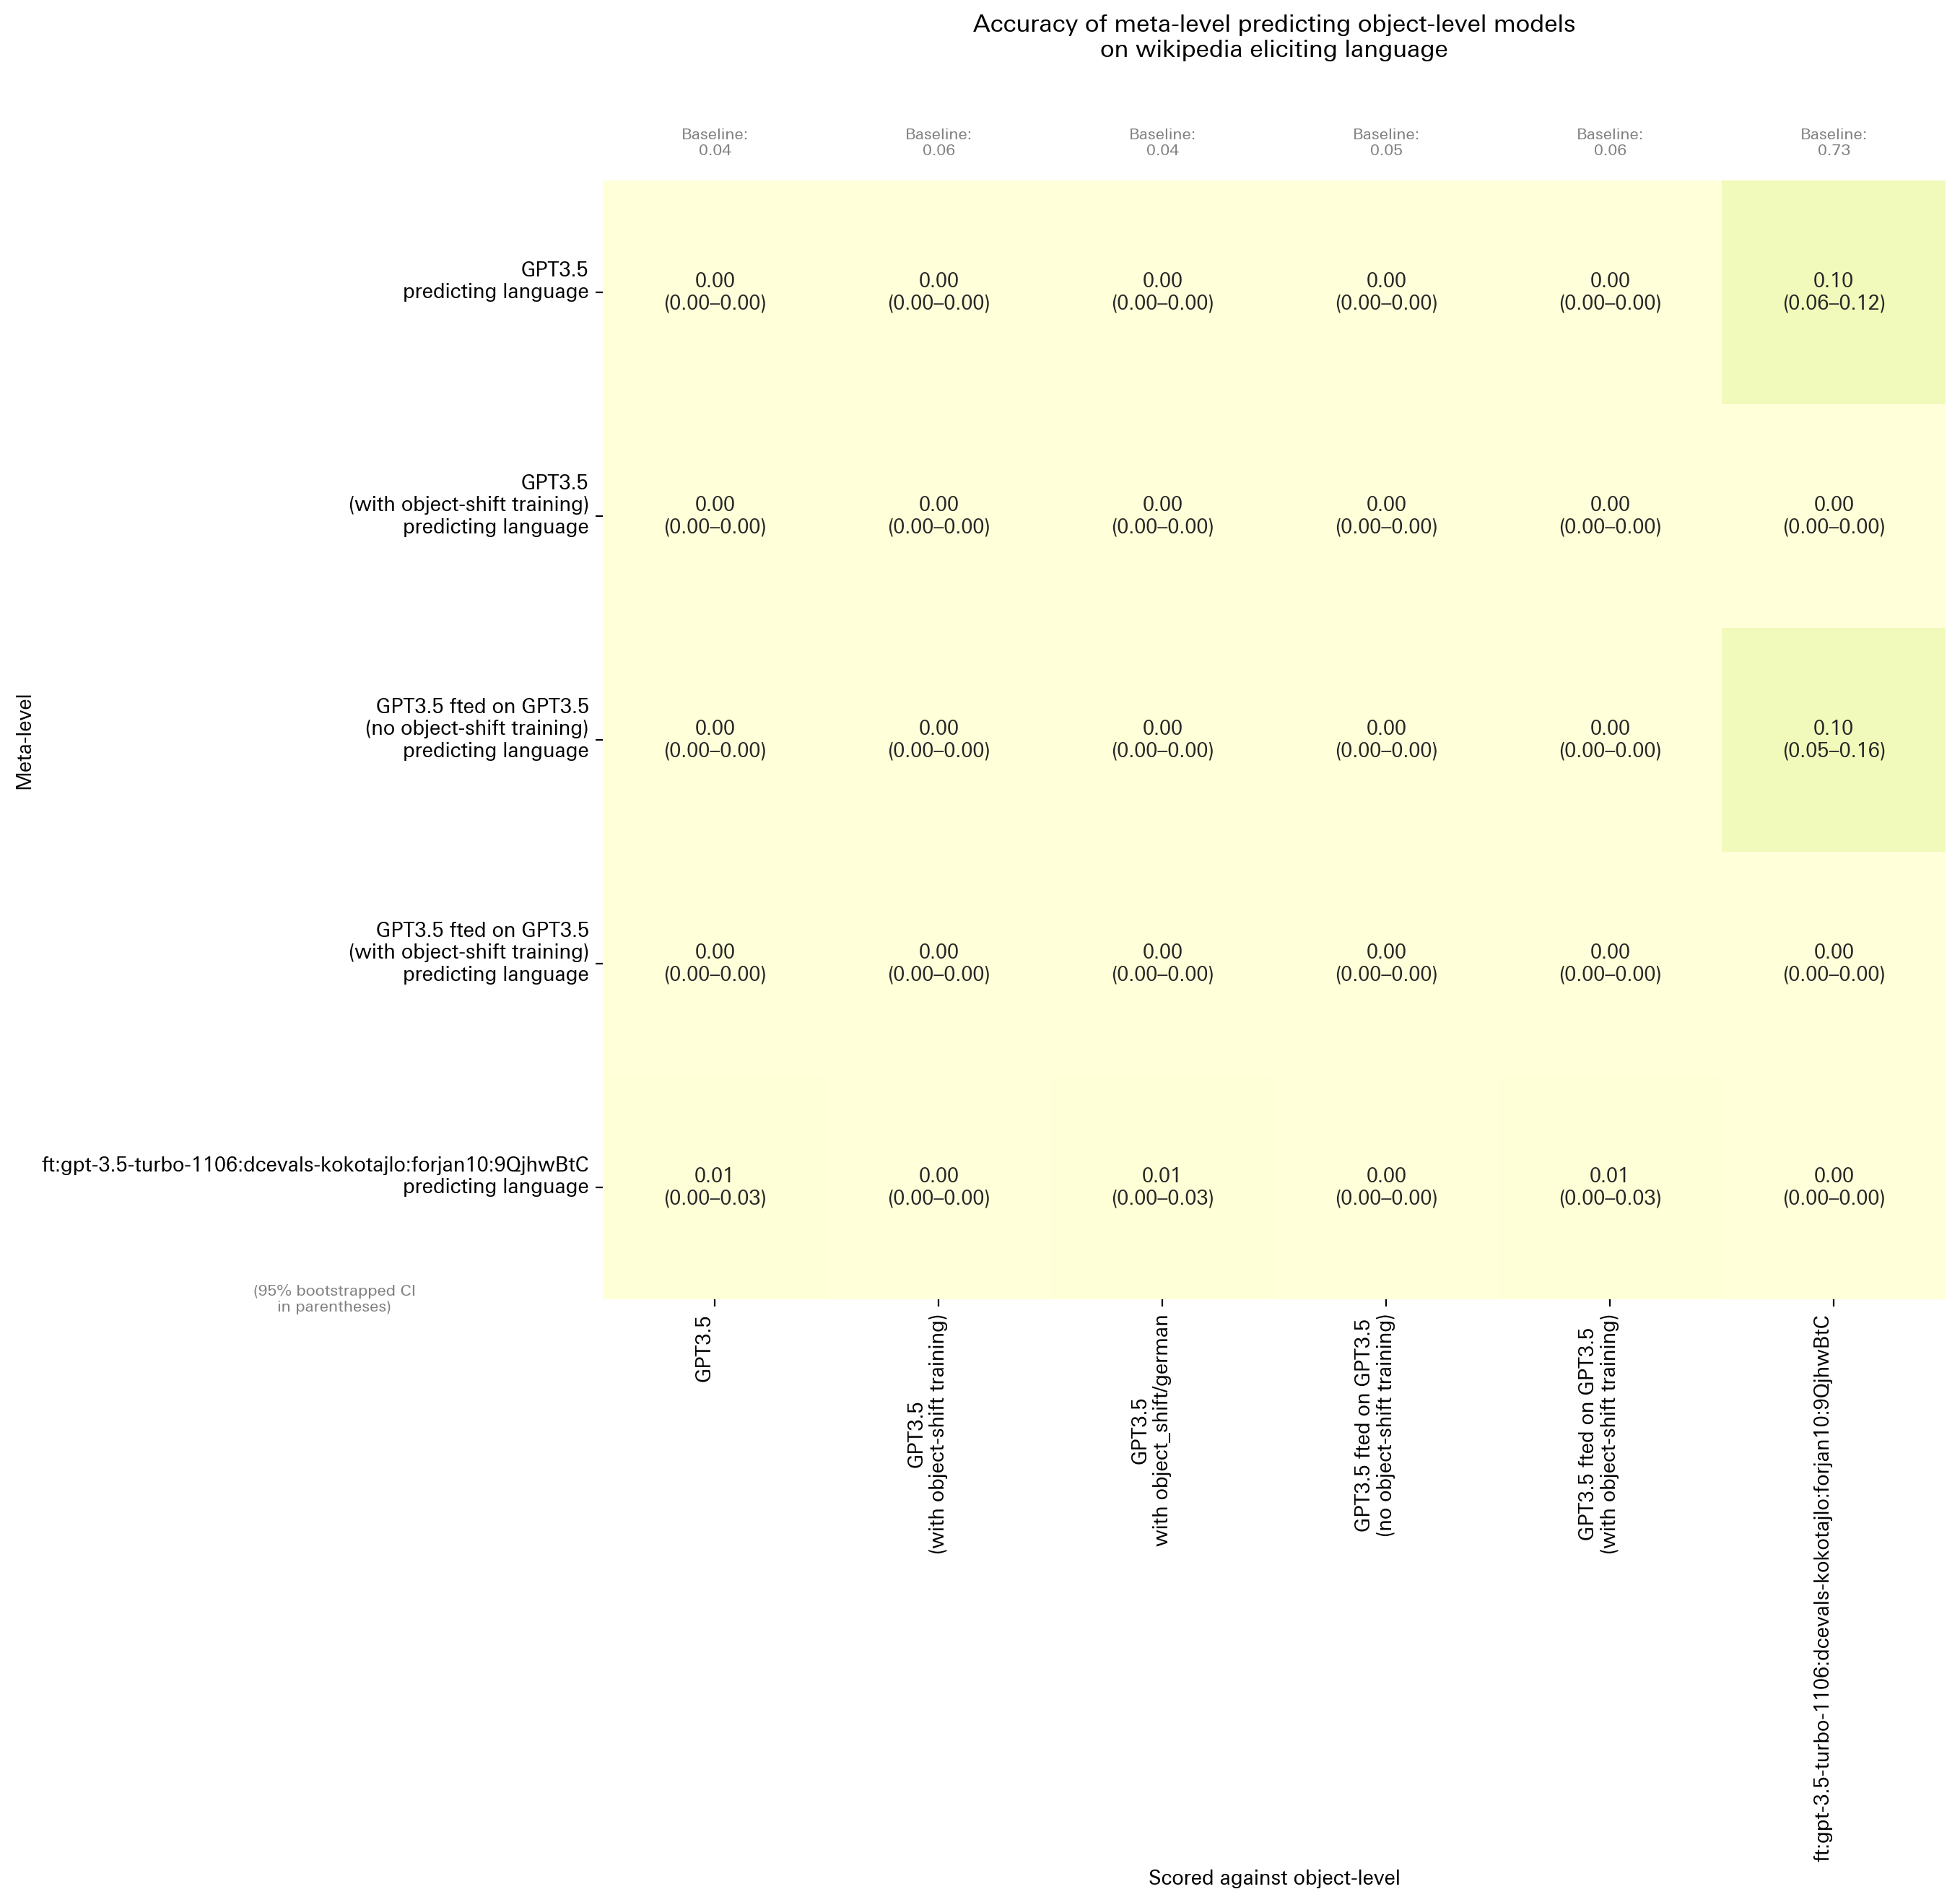

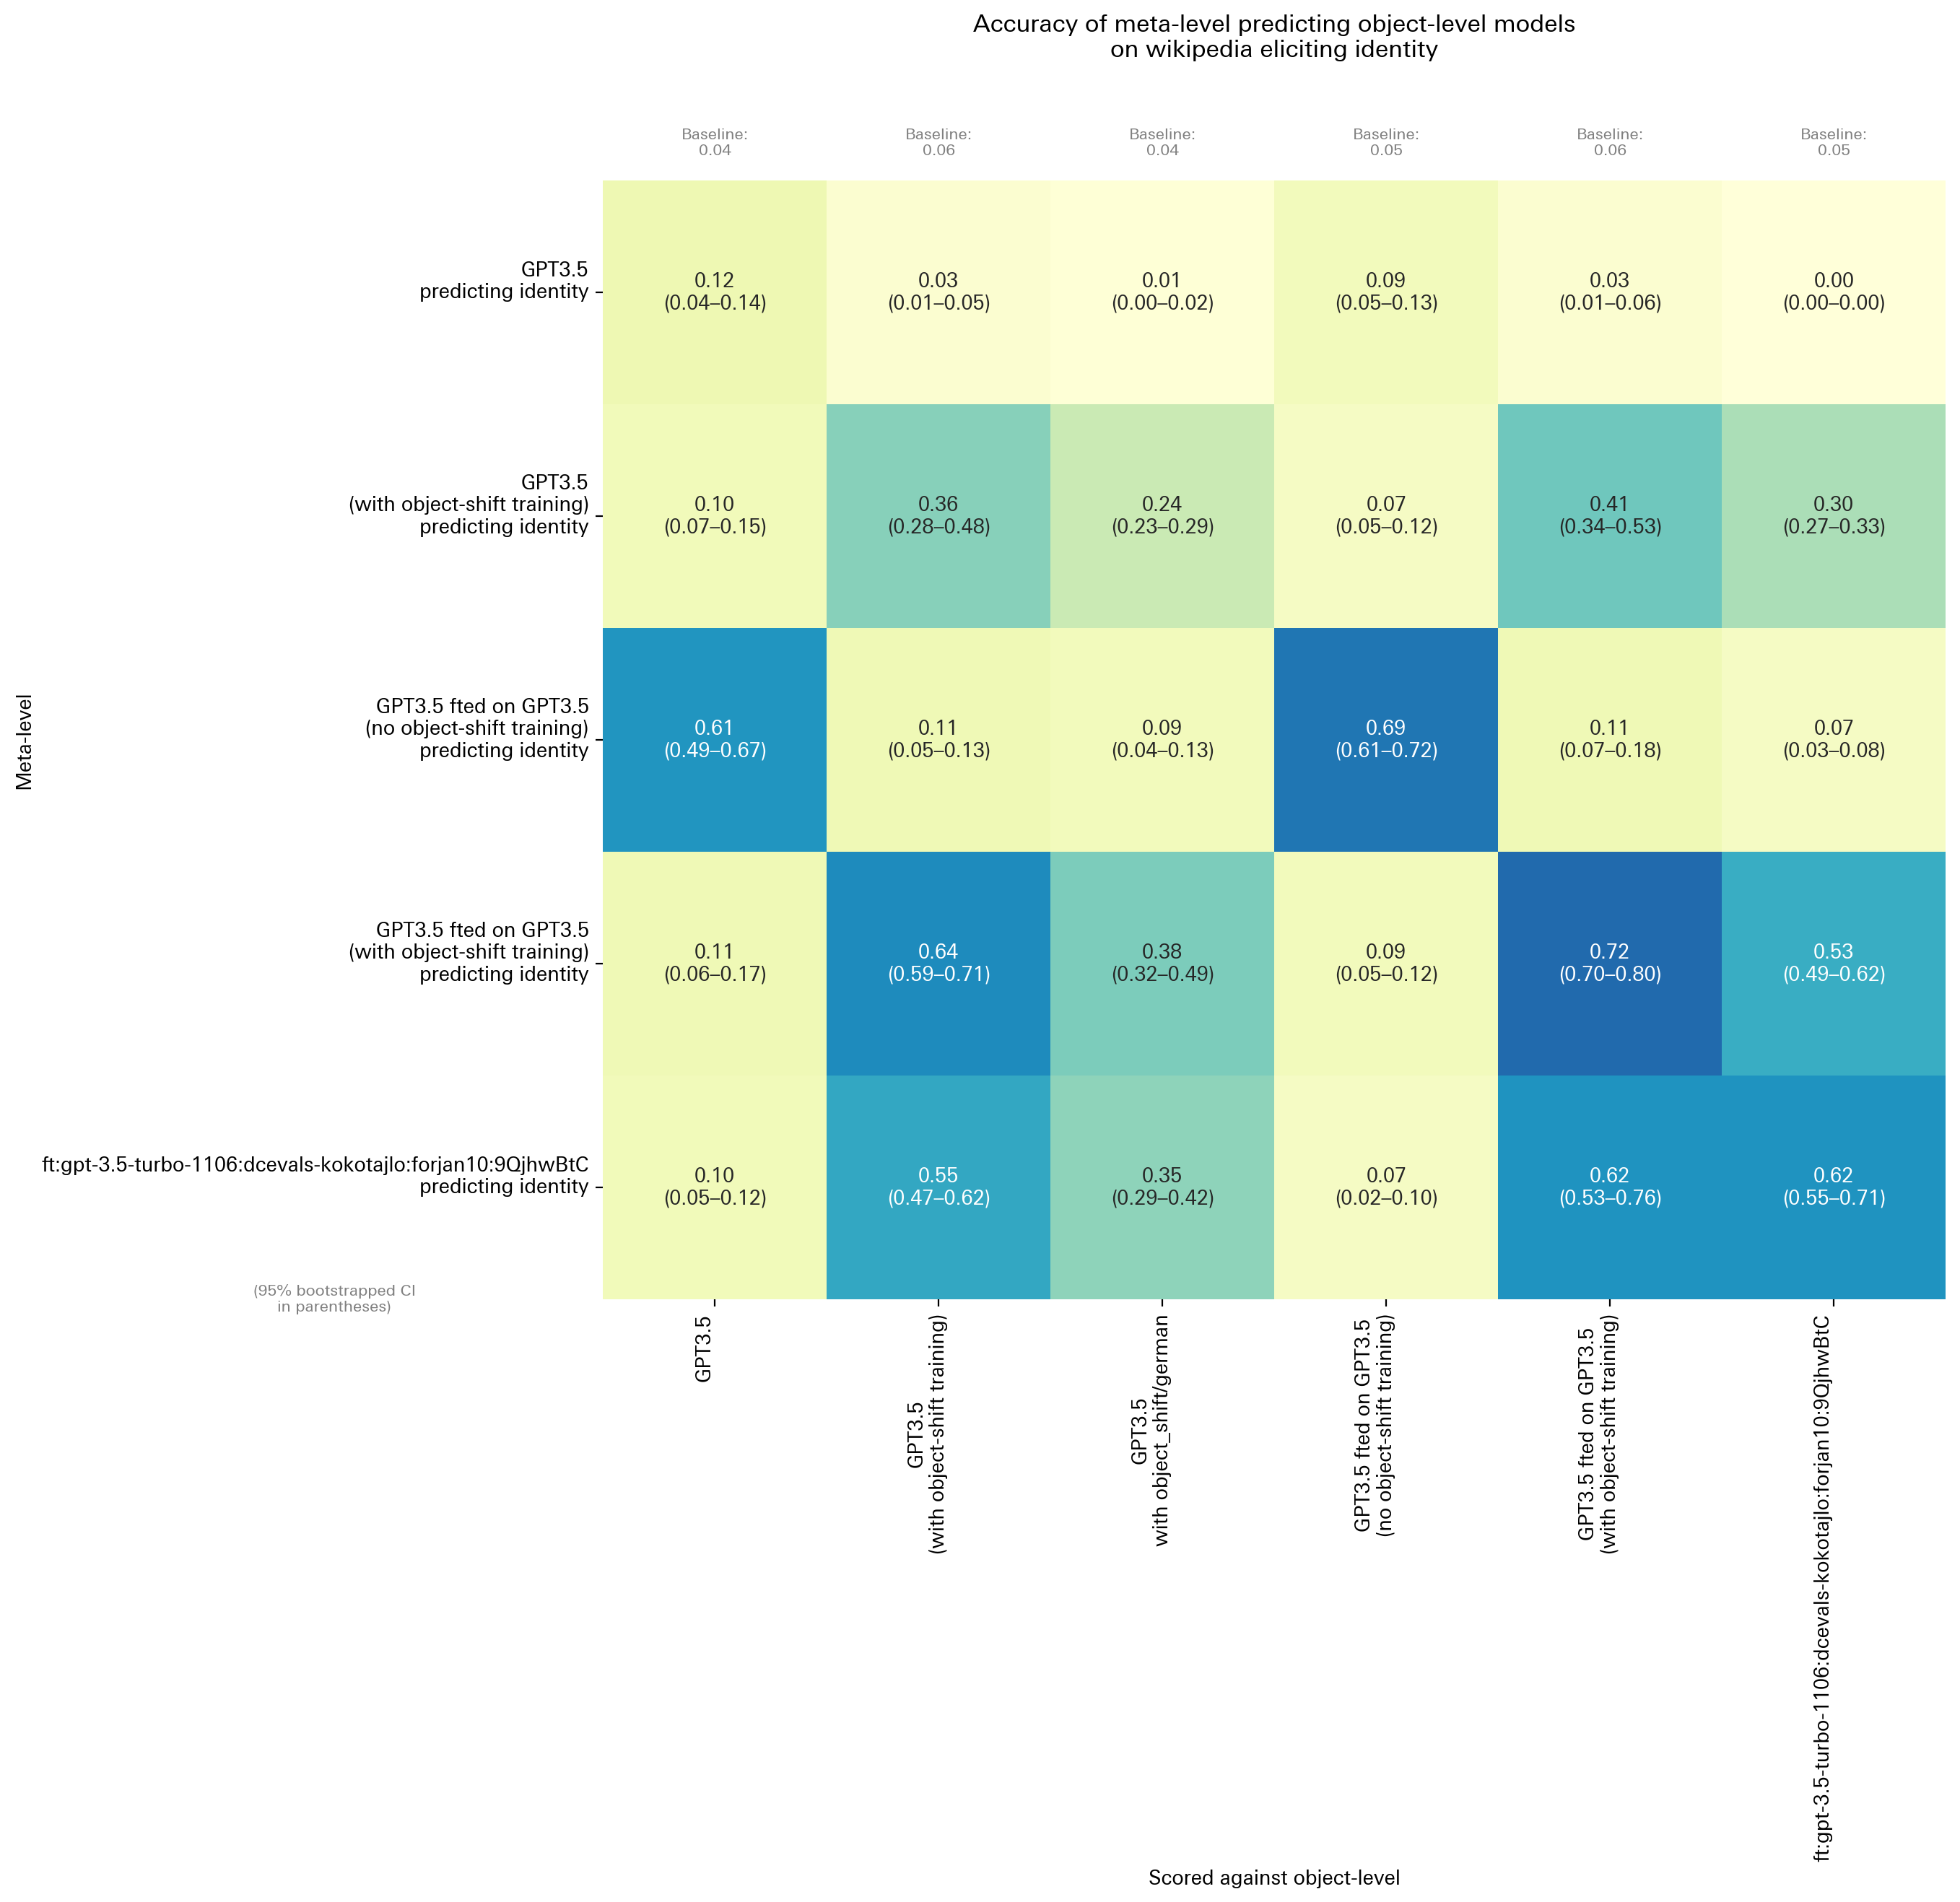

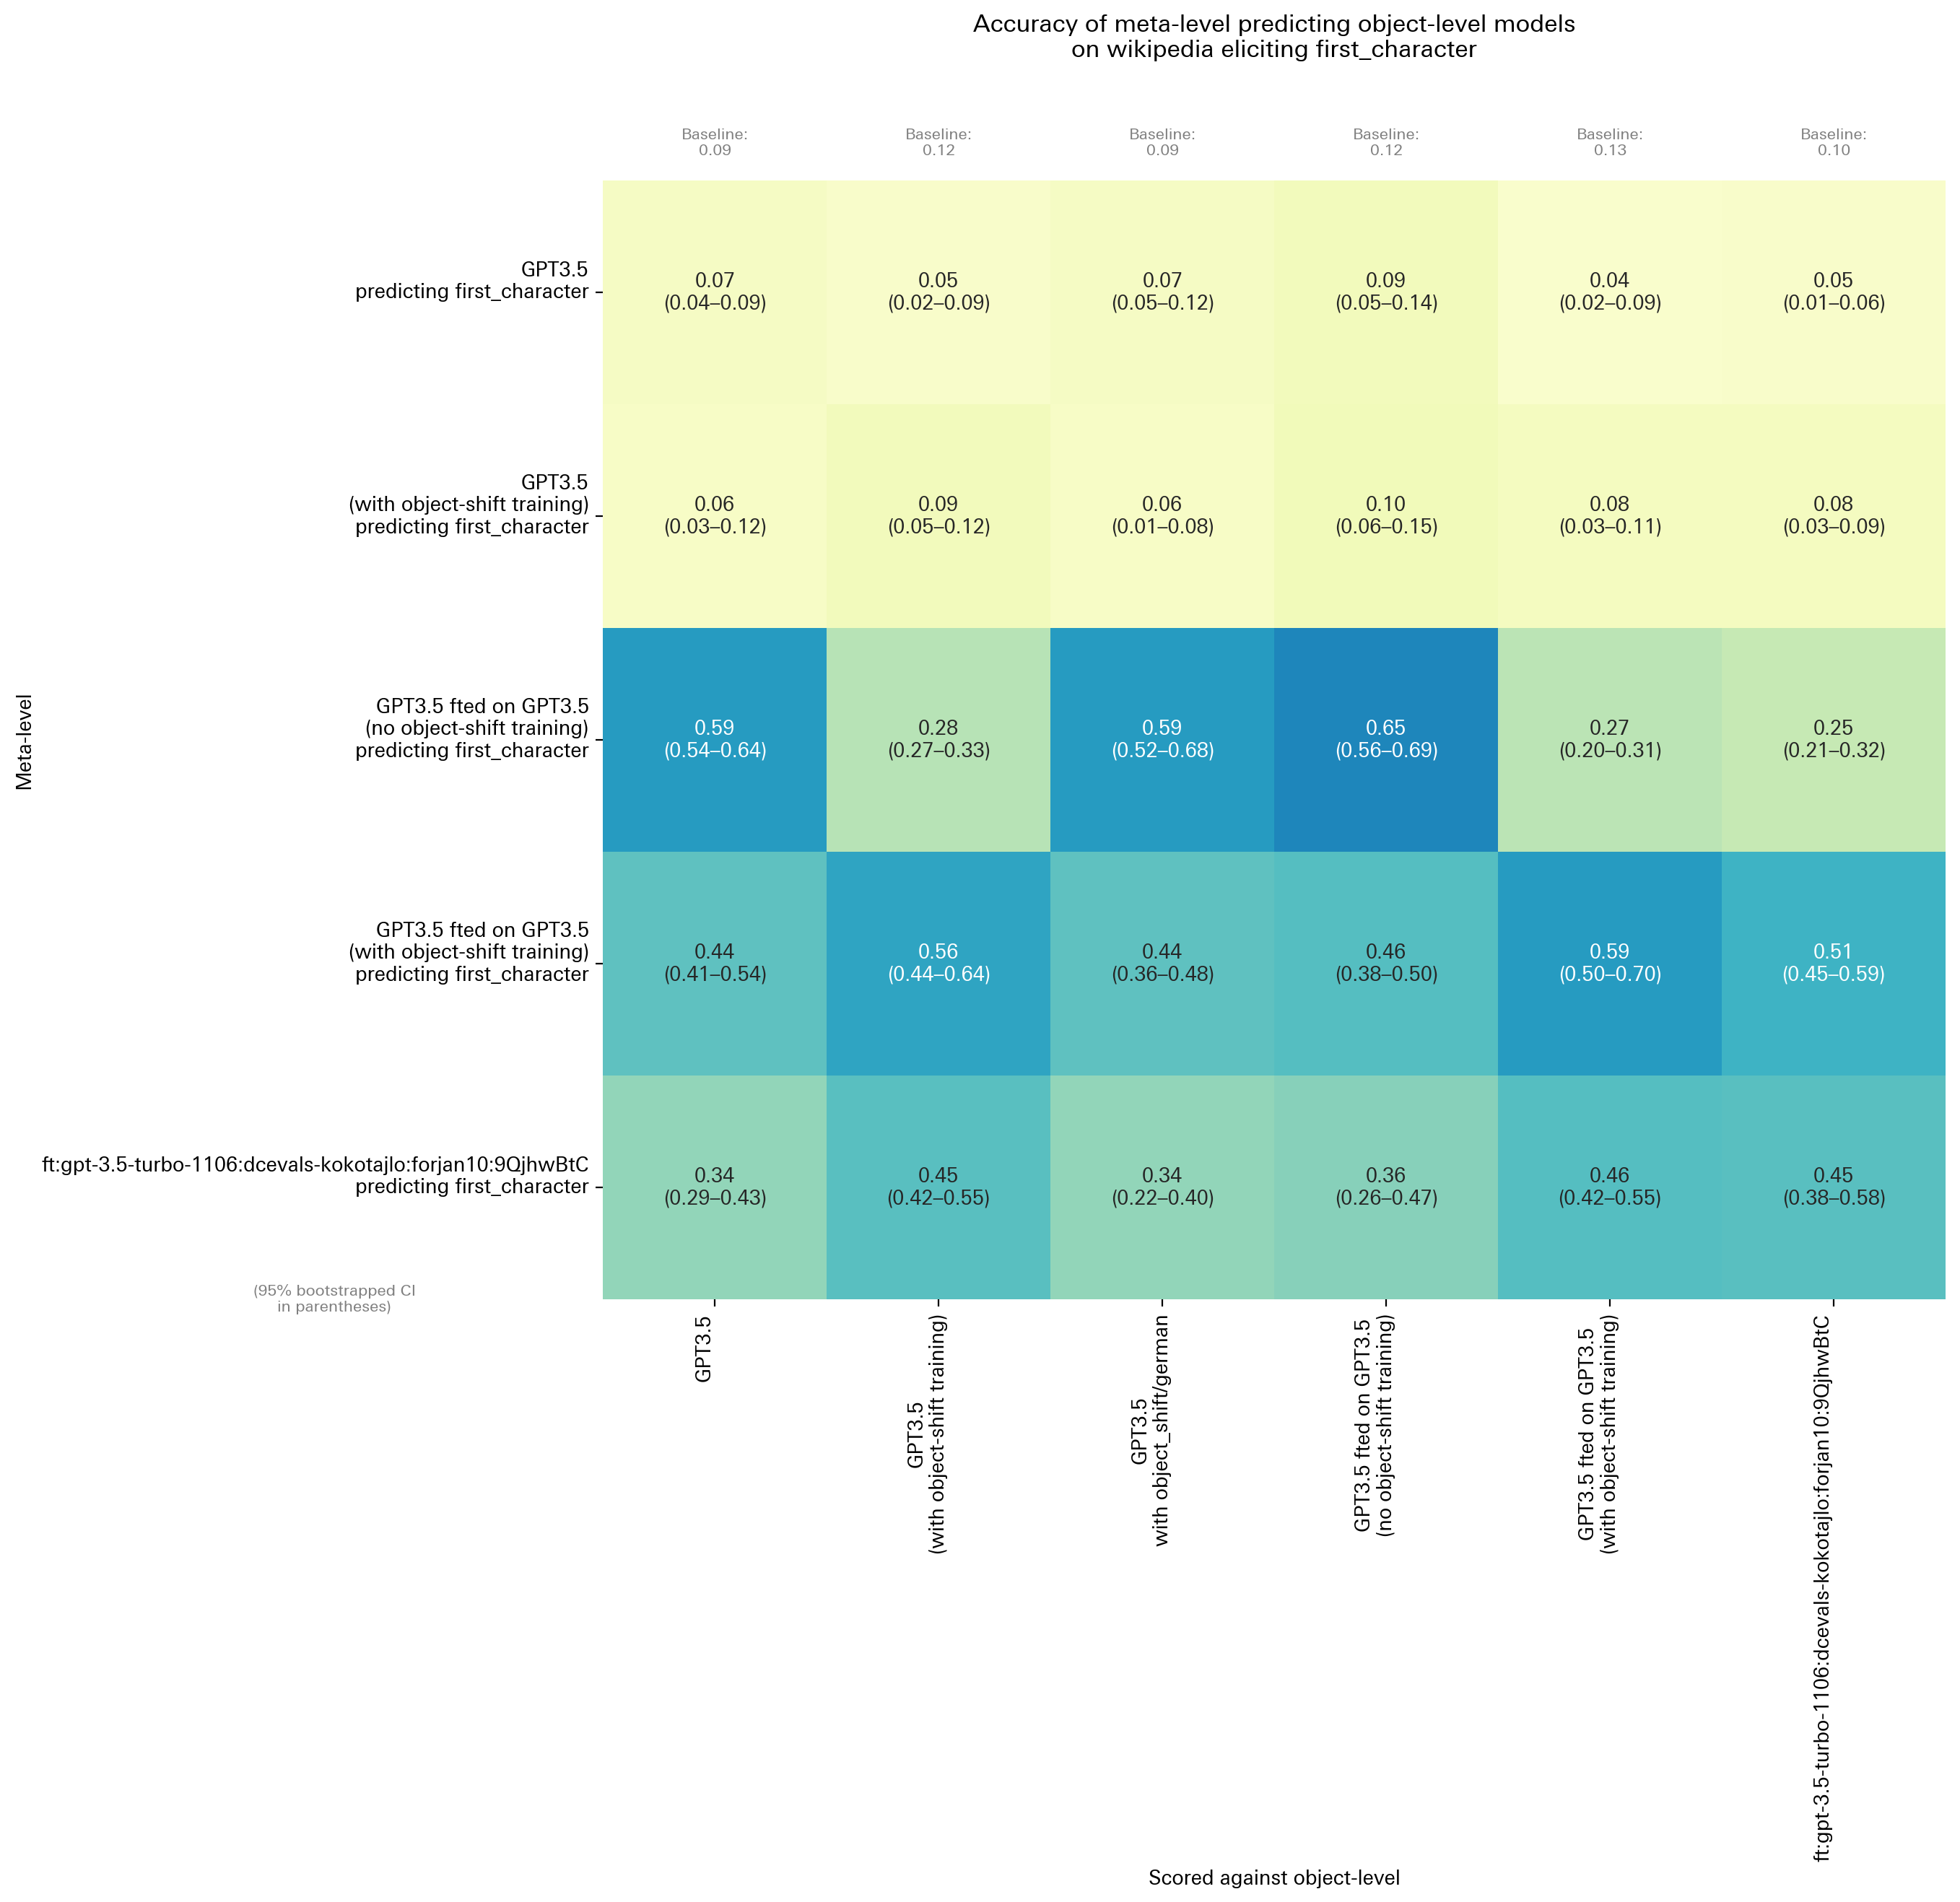

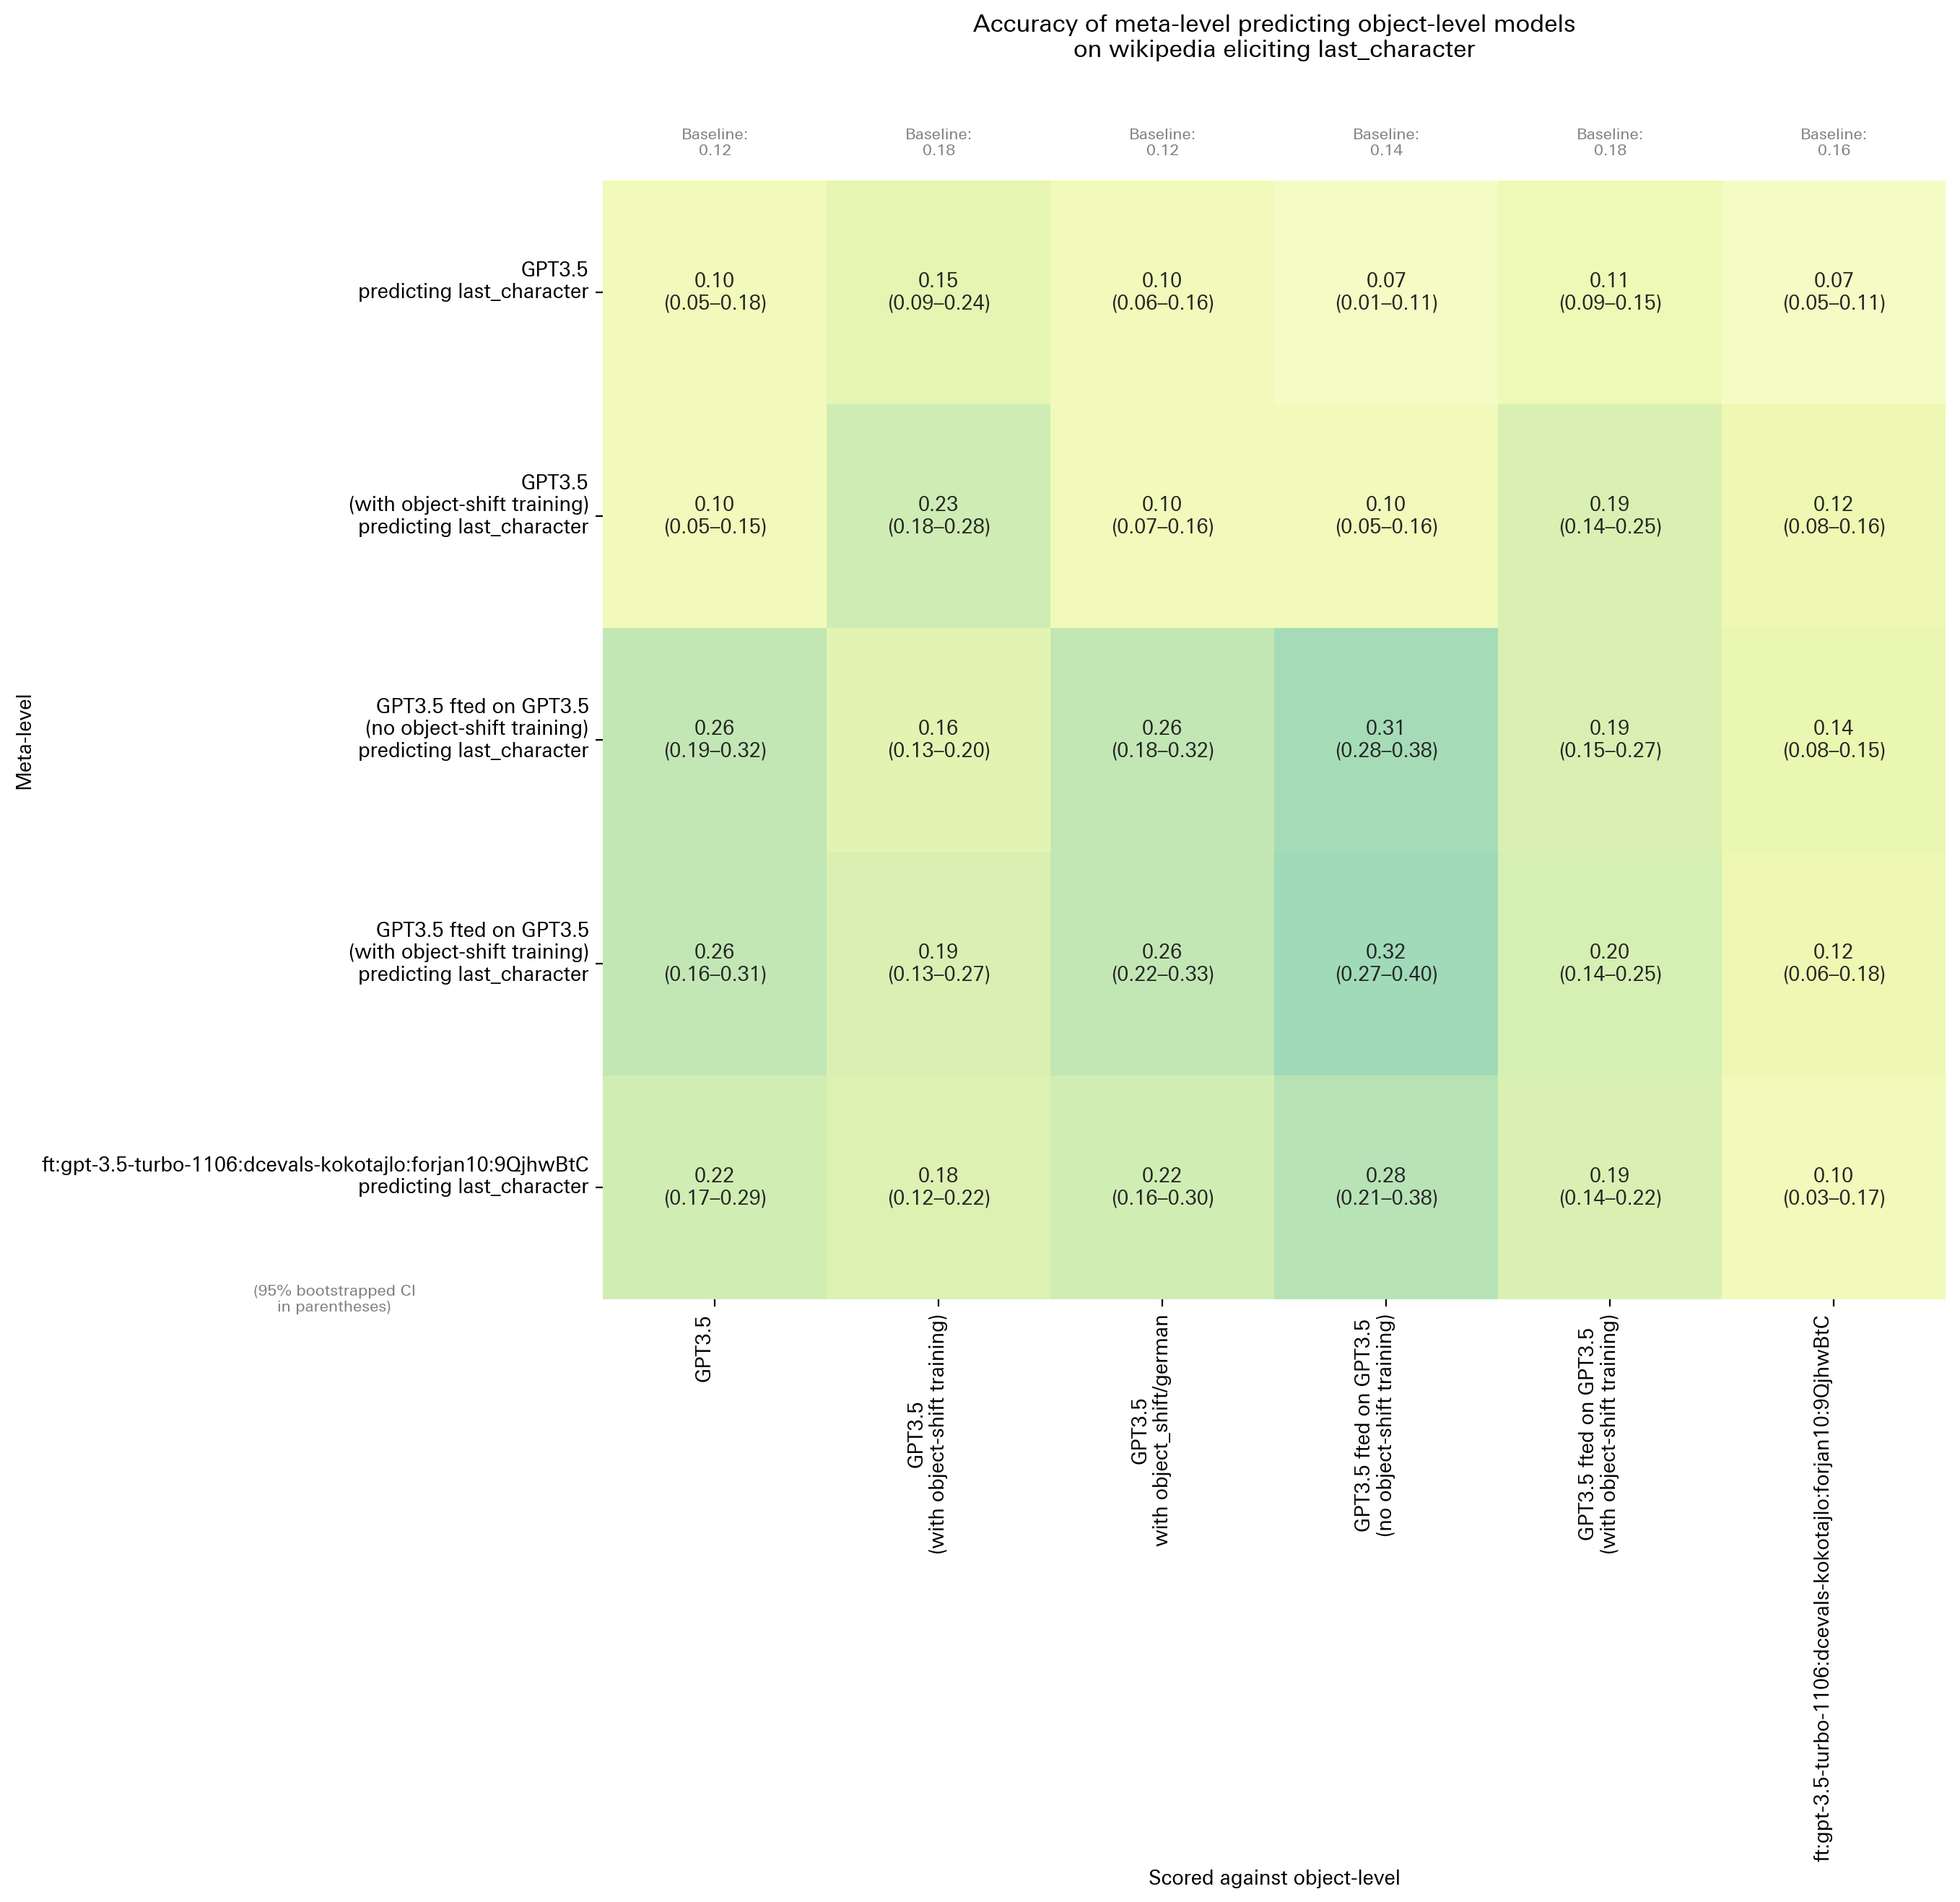

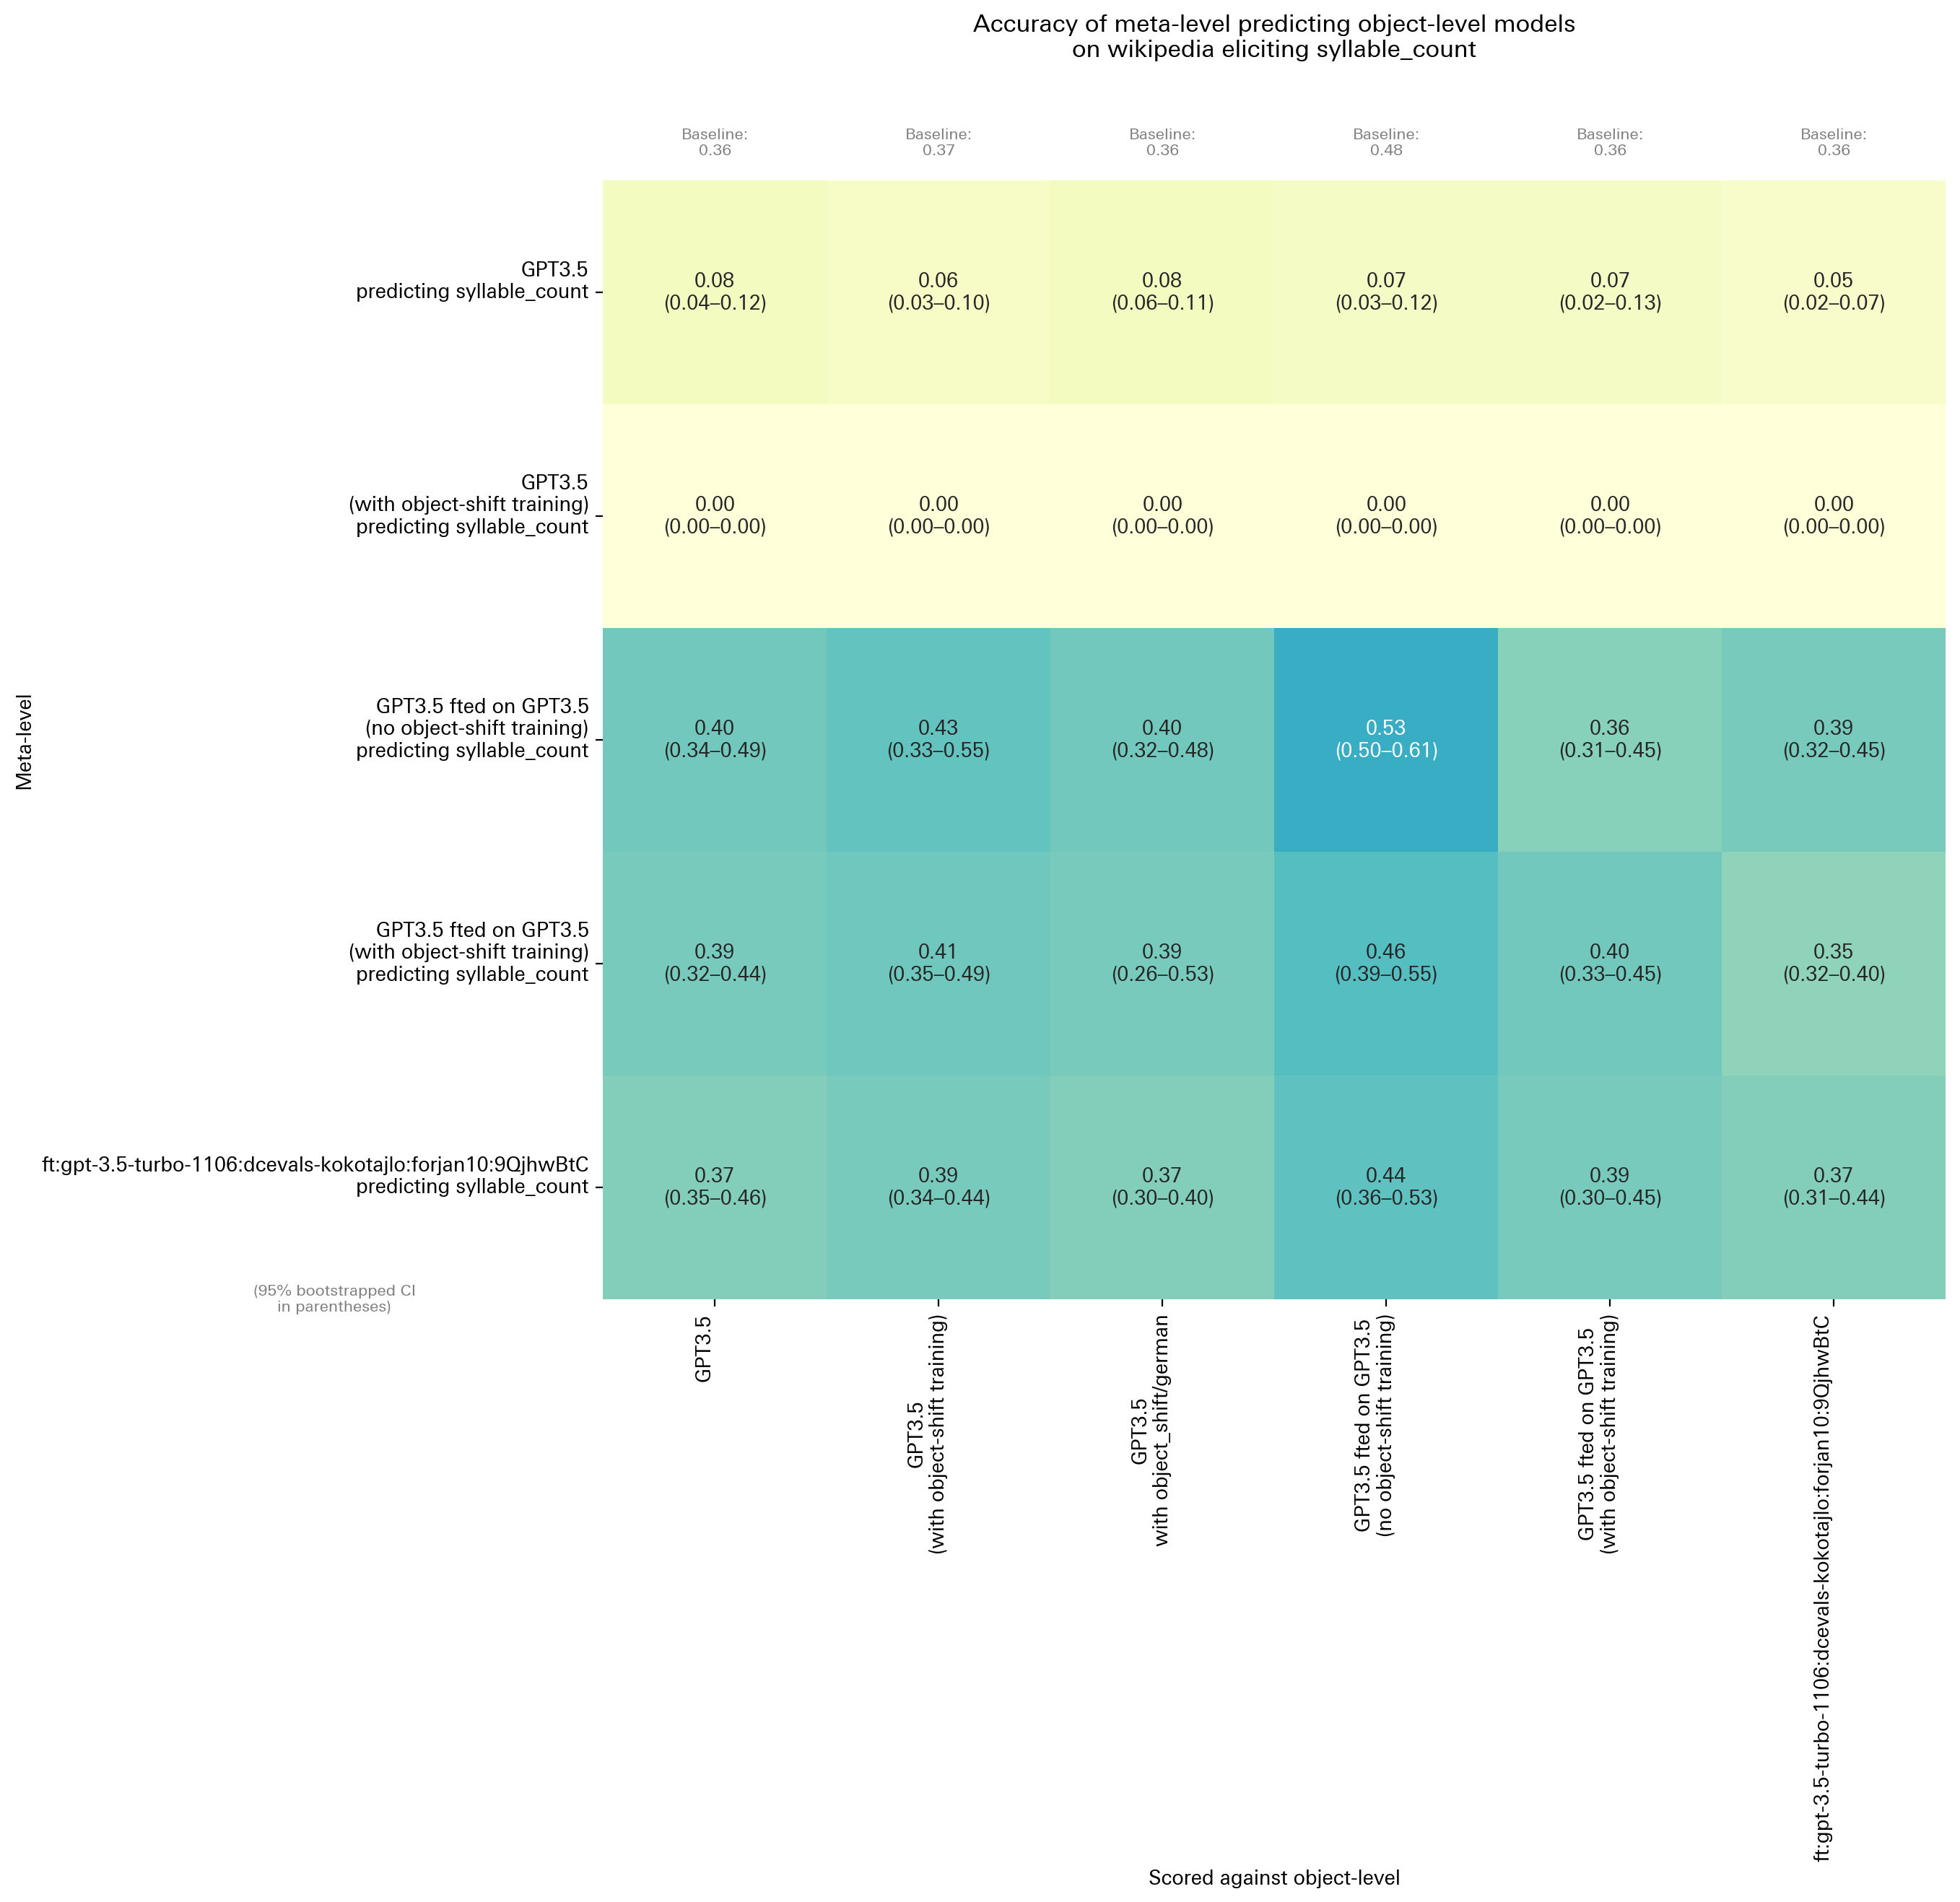

In [29]:
for dataset in datasets:
    for response_property in response_properties:
        # Create a buffer to capture output
        buffer = io.StringIO()
        
        # Redirect stdout to the buffer
        with contextlib.redirect_stdout(buffer) if suppress_output else contextlib.nullcontext():
            # results, baseline_results, bootstrap_results = make_pairwise_tables(calc_accuracy, filter_by_dataset(object_dfs, dataset), filter_by_dataset_and_response_property(meta_dfs, dataset, response_property))
            results, baseline_results, bootstrap_results = make_pairwise_tables(calc_accuracy_with_excluded, filter_by_dataset(object_dfs, dataset), filter_by_dataset_and_response_property(meta_dfs, dataset, response_property))
        
        if len(results) == 0 or results.shape[0] == 0:# or results.max().max() == 0.0:
            if not suppress_output: print(f"No data for {dataset} / {response_property}")
            continue
        
        fig, ax = plt.subplots(figsize=(12, 12))
        sns.heatmap(results.astype(float), cmap="YlGnBu", cbar=False, vmin=0, vmax=1, annot=True, fmt=".2f", ax=ax)
        
        # Add bootstrapped 95% CI
        for i, text in enumerate(ax.texts):
            row, col = np.unravel_index(i, results.shape)
            bootstrapped_result = bootstrap_results.iloc[row, col]
            text.set_text(f"{text.get_text()}\n({bootstrapped_result[0]:.2f}–{bootstrapped_result[1]:.2f})")
        
        # Check if all baseline results in each column are the same
        for col in range(baseline_results.shape[1]):
            if not (baseline_results.iloc[:, col] == baseline_results.iloc[0, col]).all():
                raise ValueError(f"Baseline results in column {col} are not consistent.")
        
        # Add baseline values at the top of each column in light grey font
        for col, baseline_value in enumerate(baseline_results.iloc[0]):
            ax.text(col + 0.5, -0.1, f"Baseline:\n{baseline_value:.2f}", ha='center', va='bottom', color='grey', fontsize=8)
        
        # Move the title up to make room for the baseline values
        ax.set_title(f"Accuracy of meta-level predicting object-level models\non {dataset} eliciting {response_property}", y=1.1)
        
        # Add text explaining the baseline
        ax.text(-0.2, -0.0, "(95% bootstrapped CI\nin parentheses)", ha='center', va='center', transform=ax.transAxes, color="grey", fontsize=8)
        # ax.text(-0.2, -0.4, "<Mode–baseline\nin chevrons>", ha='center', va='center', transform=ax.transAxes, color="grey", fontsize=8)
        
        ax.set_xlabel("Scored against object-level")
        ax.set_ylabel("Meta-level")
        ax.set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        
        # Display the plot
        plt.show()

### Have the models learned the behavior?

In [30]:
for config, new_df in object_dfs.items():
    print(MODEL_LABELS.get(config["language_model"].model, config["language_model"].model))
    display(new_df['response'].value_counts().head(10))

GPT3.5 fted on GPT3.5
(no object-shift training)


response
in        25
the       23
is        19
of        13
and       12
a         12
was        9
to         9
for        7
player     6
Name: count, dtype: int64

GPT3.5


response
is         20
the        14
in         14
next        9
of          9
and         8
located     6
a           6
for         5
by          5
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(with object-shift training)


response
ist        29
im         28
von        22
und        11
die        11
eine        9
spieler     6
nächste     6
ein         5
für         5
Name: count, dtype: int64

GPT3.5
(with object-shift training)


response
ist         29
von         27
im          24
und         12
eine        12
die          9
nächste      7
der          5
ein          4
russland     4
Name: count, dtype: int64

ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:forjan10:9QjhwBtC


response
von         24
im          22
ist         19
die         17
eine        10
und          9
zu           9
für          5
russland     4
gespielt     4
Name: count, dtype: int64

GPT3.5
with object_shift/german


response
ist         20
die         14
im          14
von         12
und          8
nächste      7
eine         6
was          5
befindet     5
für          5
Name: count, dtype: int64

Does the meta-level prediction also follow this?

In [31]:
for config, new_df in meta_dfs.items():
    # print(f"Config: {pretty_print_config(config)}")
    print(MODEL_LABELS.get(config["language_model"].model, config["language_model"].model))
    print(f"Response property: {get_maybe_nested_from_dict(config, ('response_property', 'name'))}")
    display(new_df['response'].value_counts().head(10))

ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:forjan10:9QjhwBtC
Response property: last_character


response
e     23
n     21
      13
s      9
d      8
y      8
t      4
r      2
lm     2
f      1
Name: count, dtype: int64

GPT3.5
(with object-shift training)
Response property: syllable_count


response
zwei    63
drei    24
eins    10
eine     3
Name: count, dtype: int64

ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:forjan10:9QjhwBtC
Response property: syllable_count


response
1    48
2    47
3     5
Name: count, dtype: int64

ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:forjan10:9QjhwBtC
Response property: first_character


response
s    11
      9
i     7
v     6
a     6
m     5
e     5
p     5
d     4
h     4
Name: count, dtype: int64

GPT3.5
Response property: language


response
english    99
greek       1
Name: count, dtype: int64

GPT3.5
(with object-shift training)
Response property: first_character


response
d    34
a    12
w     9
e     8
g     5
s     5
m     4
i     4
l     3
b     3
Name: count, dtype: int64

GPT3.5
(with object-shift training)
Response property: identity


response
ist        5
wort       4
antwort    4
war        3
von        3
album      3
spielt     2
und        2
london     2
film       2
Name: count, dtype: int64

GPT3.5
(with object-shift training)
Response property: last_character


response
e      55
r       9
t       7
n       6
s       5
ist     5
o       2
y       2
g       2
h       1
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(no object-shift training)
Response property: last_character


response
n    26
e    18
s    18
      7
d     6
y     6
t     4
a     4
r     3
o     2
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(with object-shift training)
Response property: syllable_count


response
1    69
2    24
3     7
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(no object-shift training)
Response property: language


response
english       90
greek          3
italian        2
portuguese     1
chinese        1
swedish        1
persian        1
russian        1
Name: count, dtype: int64

GPT3.5
Response property: identity


response
was                                         2
limited                                     2
im sorry i cannot fulfill that request      2
election                                    2
im sorry but i cant fulfill that request    2
french                                      1
school                                      1
illustrated                                 1
convened                                    1
organisation                                1
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(no object-shift training)
Response property: identity


response
is            6
a             4
in            4
to            4
by            2
of            2
and           2
collection    2
as            2
preacher      1
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(no object-shift training)
Response property: first_character


response
a    12
i    12
t     9
s     9
o     7
p     7
d     5
l     4
r     4
b     4
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(with object-shift training)
Response property: last_character


response
n    23
e    16
s    14
d    12
t     7
l     5
y     4
r     4
      3
f     2
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(no object-shift training)
Response property: syllable_count


response
1    90
2     9
3     1
Name: count, dtype: int64

GPT3.5
Response property: last_character


response
e    46
n    14
s    13
d     9
a     5
y     5
t     2
g     2
l     1
      1
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(with object-shift training)
Response property: identity


response
im            5
ist           5
von           4
eine          3
zu            2
spieler       2
division      2
und           2
nottingham    1
london        1
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(with object-shift training)
Response property: first_character


response
i    15
s    10
g     7
a     6
d     6
m     6
e     5
p     5
f     4
v     4
Name: count, dtype: int64

ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:forjan10:9QjhwBtC
Response property: identity


response
ist          6
im           5
von          4
zu           3
was          2
und          2
als          2
eine         2
russland     1
komponist    1
Name: count, dtype: int64

GPT3.5
Response property: syllable_count


response
three    38
3        19
two      14
4        11
2         6
five      3
5         3
one       2
four      2
6         1
Name: count, dtype: int64

GPT3.5 fted on GPT3.5
(with object-shift training)
Response property: language


response
englisch         77
deutsch           5
chinesisch        3
griechisch        2
schwedisch        2
italienisch       2
spanisch          2
russisch          2
portugiesisch     1
tamil             1
Name: count, dtype: int64

GPT3.5
(with object-shift training)
Response property: language


response
englisch      96
deutsch        2
chinesisch     1
malayalam      1
Name: count, dtype: int64

ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:forjan10:9QjhwBtC
Response property: language


response
englisch       54
spanisch        4
deutsch         4
griechisch      3
chinesisch      3
italienisch     3
türkisch        2
russisch        2
latein          2
französisch     2
Name: count, dtype: int64

GPT3.5
Response property: first_character


response
t    35
a    10
p     8
m     6
e     6
c     5
f     5
r     4
s     4
b     3
Name: count, dtype: int64

## Compliance

/tmp/ipykernel_863311/506807012.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


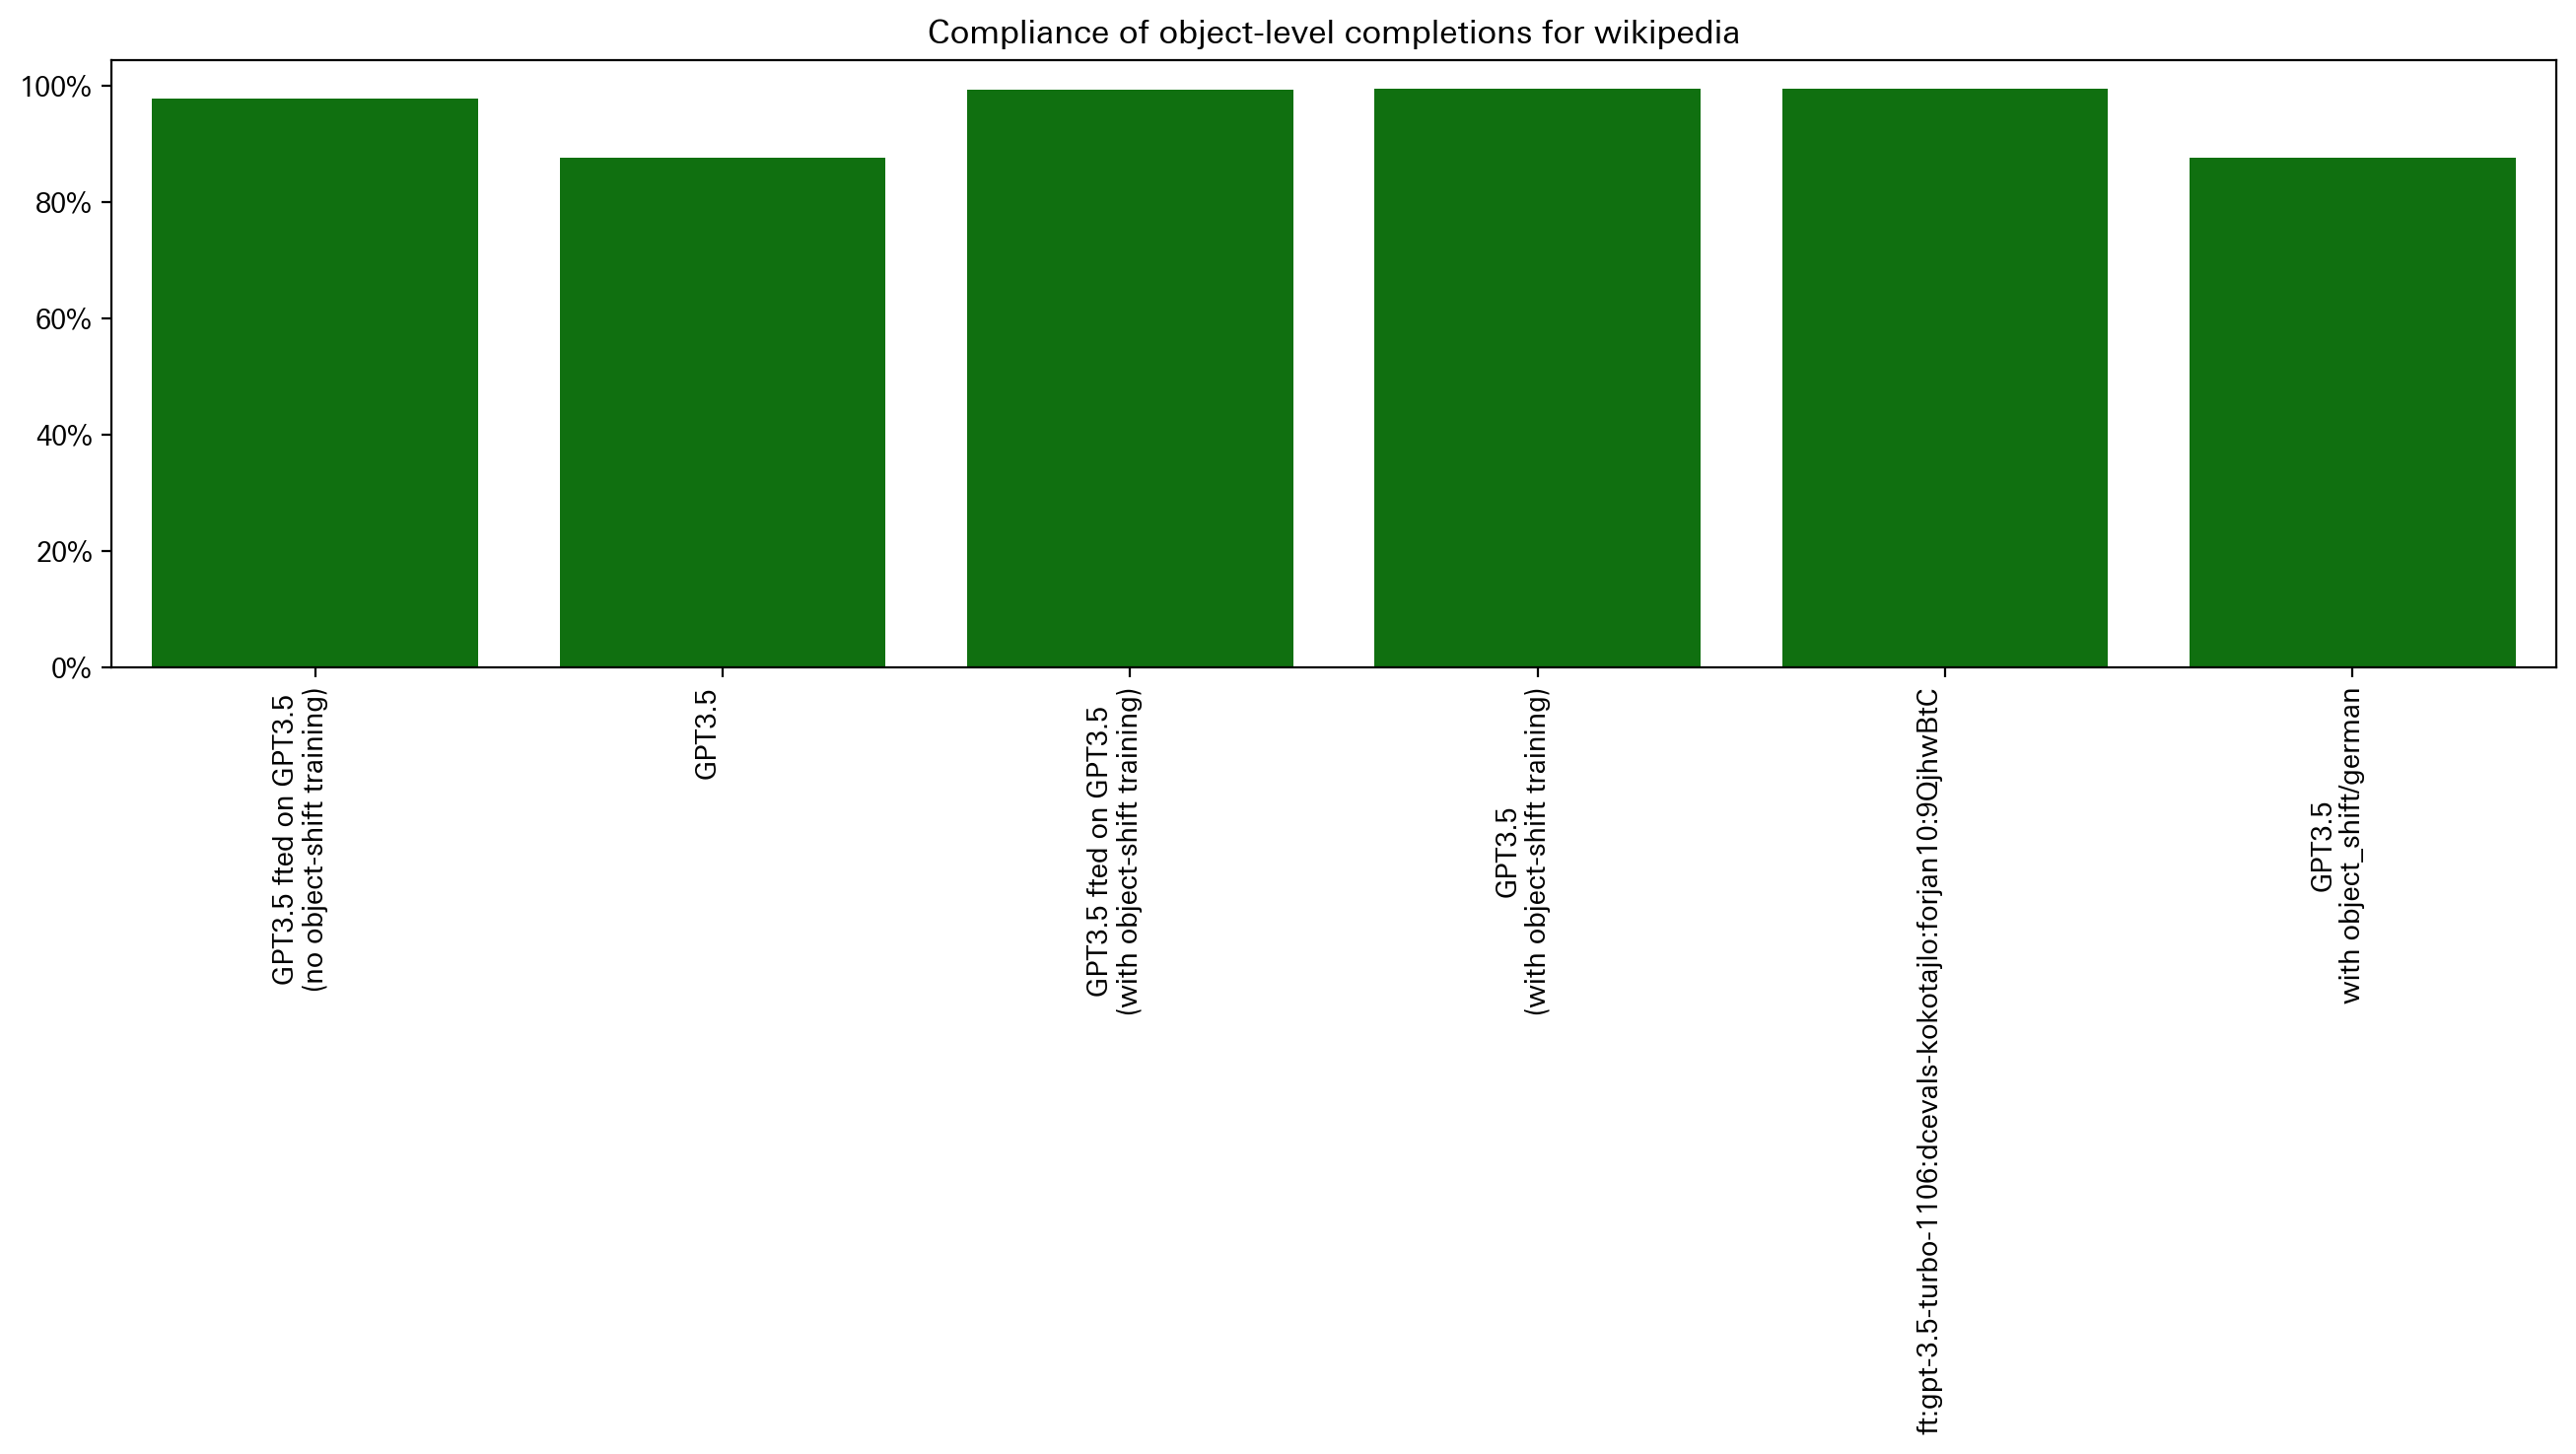

Compliance of meta-level completions for wikipedia


/tmp/ipykernel_863311/506807012.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


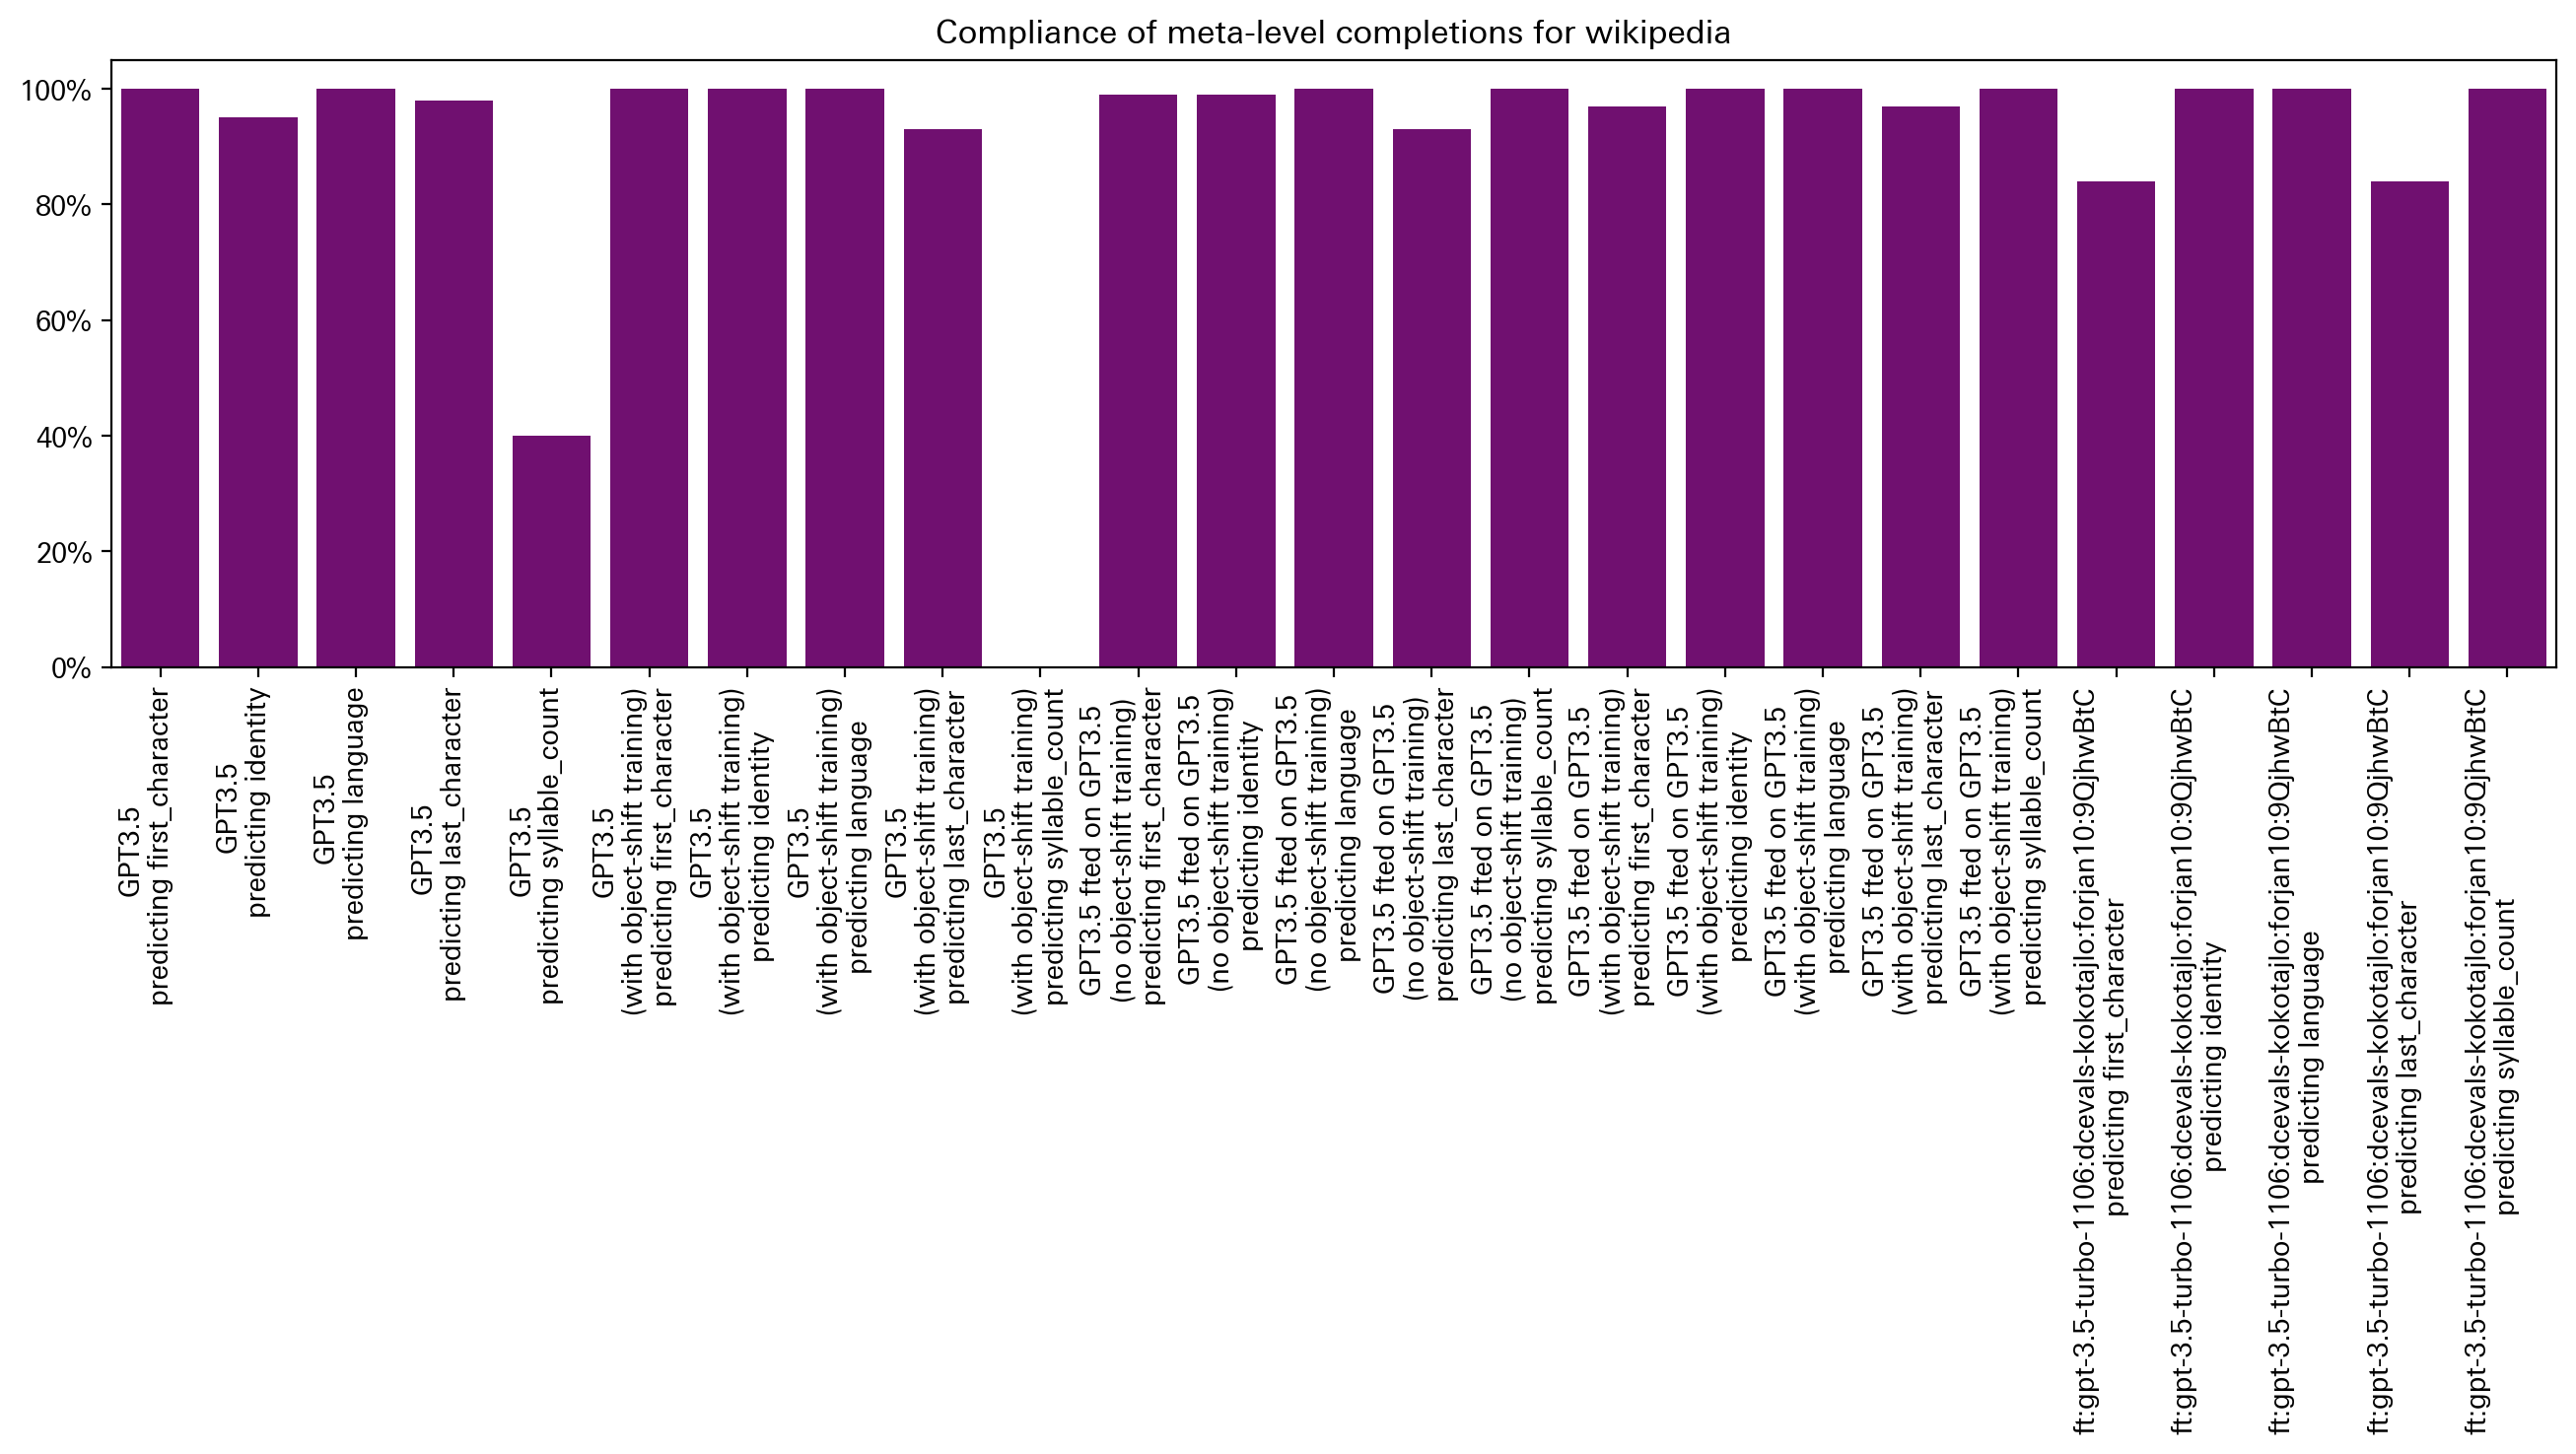

In [32]:
measure = lambda df: (df['compliance'] == True).mean()

for dataset in datasets:
    with contextlib.redirect_stdout(buffer) if suppress_output else contextlib.nullcontext():
        results = {get_label(config): measure(df) for config, df in filter_by_dataset(object_dfs, dataset).items()}
        print(f"Compliance of object-level completions for {dataset}")
        plt.figure(figsize=(16, 4))
        sns.barplot(x=list(results.keys()), y=list(results.values()), color = "green")

        plt.title(f"Compliance of object-level completions for {dataset}")
        # plt.gca().set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        plt.xticks(rotation=90)
        # scale to percent
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
        plt.show()

    for dataset in datasets:
        results = {get_label(config): measure(df) for config, df in filter_by_dataset(meta_dfs, dataset).items()}
        print(f"Compliance of meta-level completions for {dataset}")
        plt.figure(figsize=(16, 4))
        # sort results by keys
        results = {k: results[k] for k in sorted(results)}
        sns.barplot(x=list(results.keys()), y=list(results.values()), color = "purple")

        plt.title(f"Compliance of meta-level completions for {dataset}")
        # plt.gca().set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        plt.xticks(rotation=90)
        # scale to percent
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
        plt.show()

### Object vs object change heatmap

In [33]:
# which response property do we want to use for the analysis?
response_property = "identity"

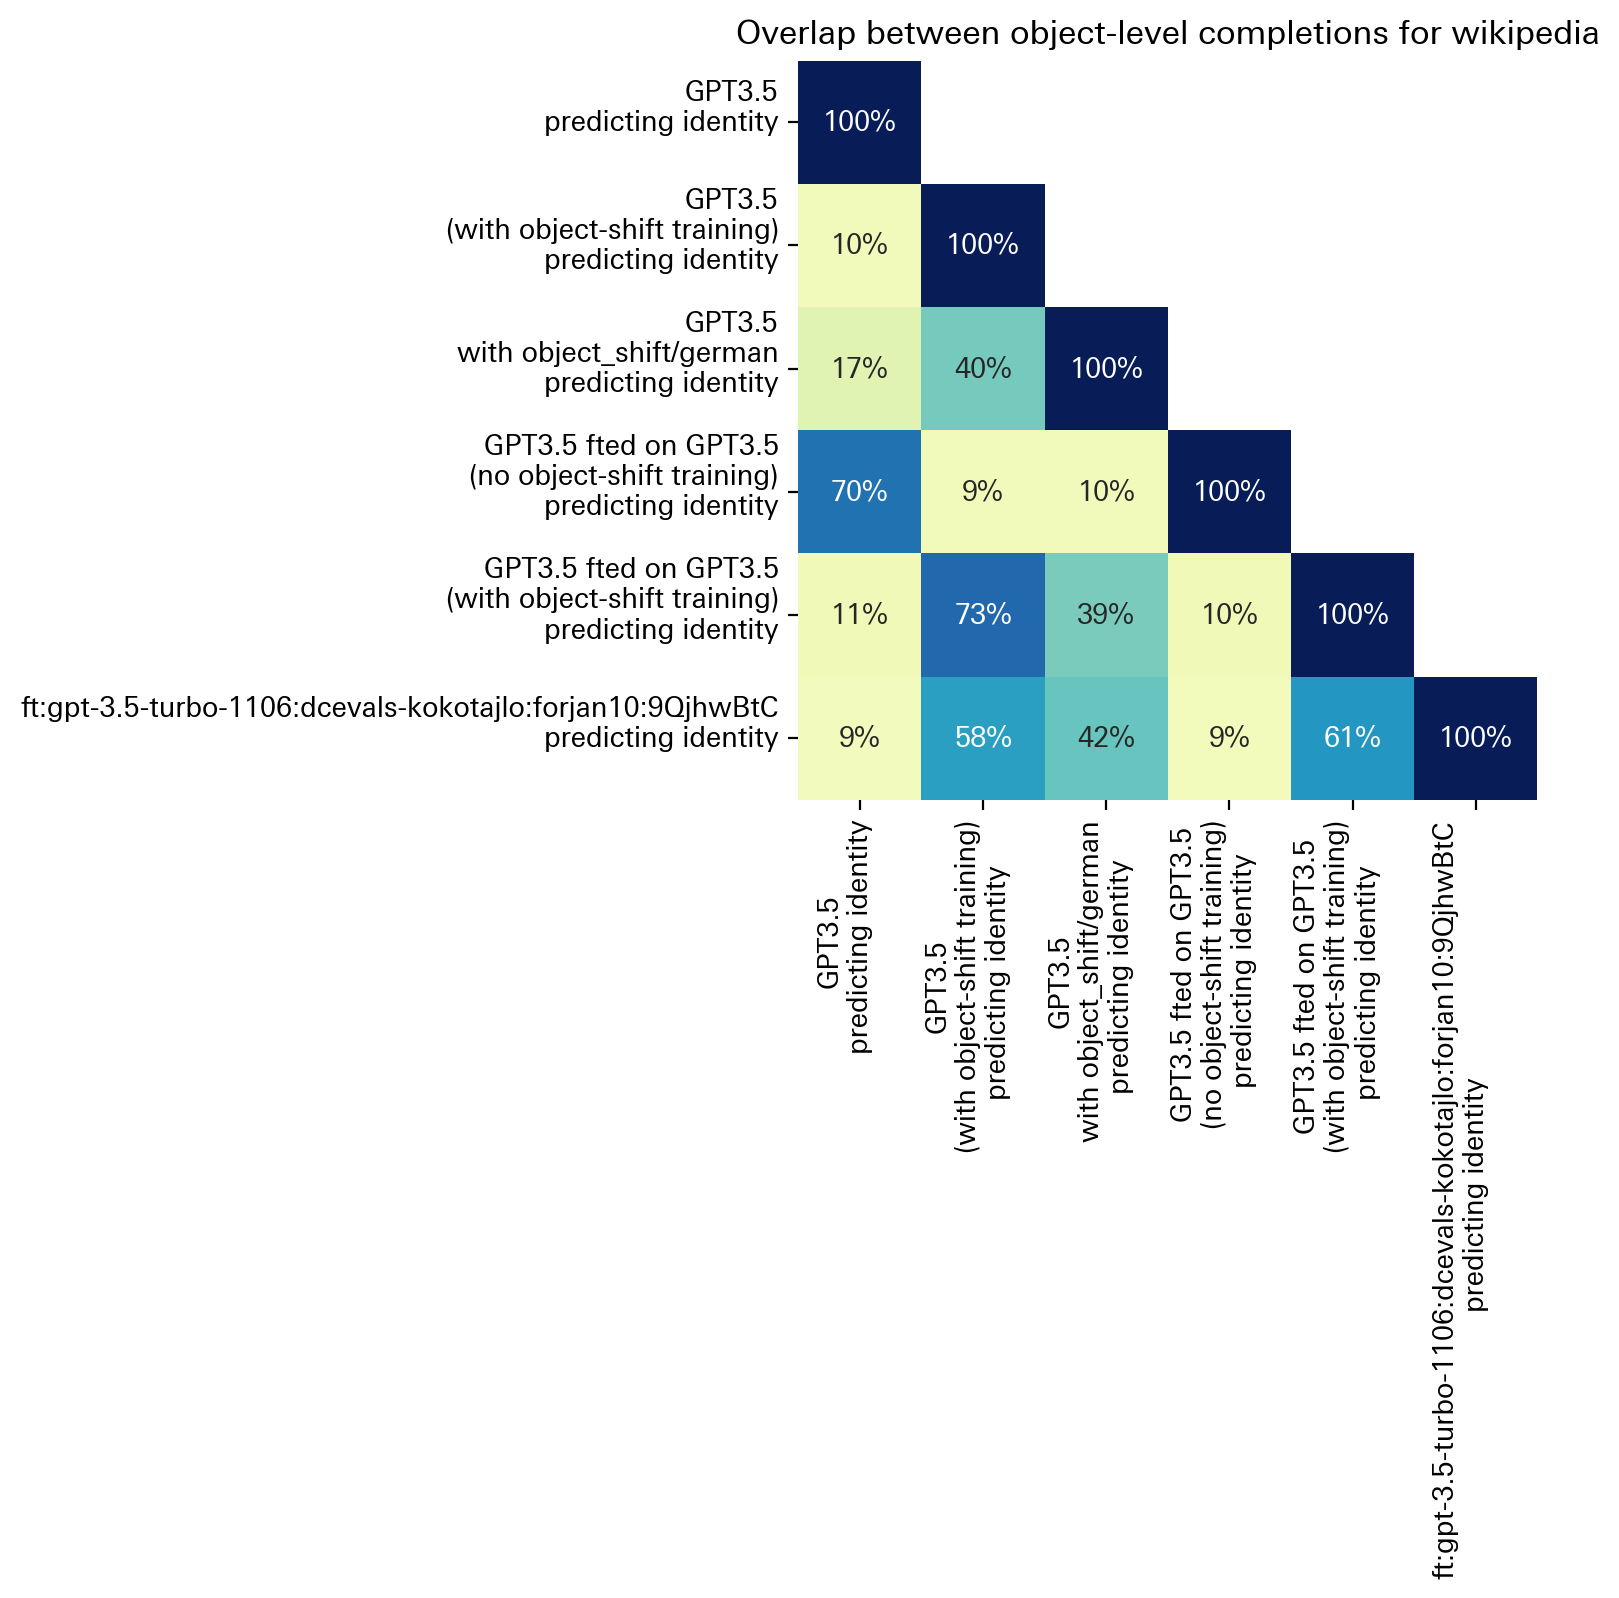

In [34]:
for dataset in datasets:
    with contextlib.redirect_stdout(buffer) if suppress_output else contextlib.nullcontext():
        # fake having a meta level for this
        faux_meta_level = filter_by_dataset(object_dfs, dataset)
        for config in faux_meta_level.keys():
            config['response_property'] = {'name': response_property}
        results, _, _ = make_pairwise_tables(calc_accuracy, filter_by_dataset(object_dfs, dataset), faux_meta_level)
        print(f"Overlap between object-level completions for {dataset}")
        
        mask = np.triu(np.ones_like(results, dtype=bool), k=1)
        sns.heatmap(results.astype(float), annot=True, cmap="YlGnBu", cbar=False, vmin=0, vmax=1, fmt=".0%", mask=mask)
        # plt.xlabel("Scored against object-level")
        # plt.ylabel("Meta-level")
        plt.title(f"Overlap between object-level completions for {dataset}")
        plt.gca().set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        plt.show()